# Difference-in-Differences Analysis for Cooling Interventions

This notebook implements DiD analysis to evaluate cooling interventions effectiveness.

## Data Preparation Steps:
1. Load and prepare master dataframe
2. Create treatment and control groups
3. Define pre and post intervention periods
4. Calculate necessary variables for DiD analysis

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from datetime import datetime, timedelta

# Load the master dataframe and logger flags
master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
logger_flags_df = pd.read_csv('logger_flags.csv')

# Set DateTime as index
master_df = master_df.set_index('DateTime')

# Create dictionary for logger metadata
logger_metadata = logger_flags_df.set_index('Loggers').to_dict('index')

# Define intervention dates
rainbow_intervention_date = pd.to_datetime('2024-07-16')
sports_intervention_date = pd.to_datetime('2024-07-20')

# Display basic information
print('Master dataframe shape:', master_df.shape)
print('\nLogger flags shape:', logger_flags_df.shape)
print('\nLogger flags columns:', logger_flags_df.columns.tolist())

Master dataframe shape: (90832, 46)

Logger flags shape: (42, 9)

Logger flags columns: ['Loggers', 'Shaded', 'Unshaded', 'Settlement', 'Intervention', 'Logger_Type', 'Baseline_Start', 'Intervention_Start', 'Post_Intervention_End']


In [3]:
logger_flags_df.head()

,Loggers,Shaded,Unshaded,Settlement,Intervention,Logger_Type,Baseline_Start,Intervention_Start,Post_Intervention_End
0,R-01,False,True,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06
1,R-02,False,True,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06
2,R-04,True,False,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06
3,R-05,False,True,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06
4,R-06,False,True,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06


In [4]:
# Create treatment indicators
treatment_groups = {
    'RBF': logger_flags_df[logger_flags_df['Intervention'] == 'RBF']['Loggers'].tolist(),
    'MEB': logger_flags_df[logger_flags_df['Intervention'] == 'MEB']['Loggers'].tolist(),
    'Control': logger_flags_df[logger_flags_df['Intervention'] == 'CONTROL']['Loggers'].tolist()
}

# Create settlement indicators
settlements = {
    'Rainbow Field': logger_flags_df[logger_flags_df['Settlement'] == 'Rainbow Field']['Loggers'].tolist(),
    'Sports Complex': logger_flags_df[logger_flags_df['Settlement'] == 'Sports Complex']['Loggers'].tolist()
}

# Create shading indicators
shading = {
    'Shaded': logger_flags_df[logger_flags_df['Shaded'] == True]['Loggers'].tolist(),
    'Unshaded': logger_flags_df[logger_flags_df['Shaded'] == False]['Loggers'].tolist()
}

print("Number of loggers in each treatment group:")
for group, loggers in treatment_groups.items():
    print(f"{group}: {len(loggers)}")

print("\nNumber of loggers in each settlement:")
for settlement, loggers in settlements.items():
    print(f"{settlement}: {len(loggers)}")

print("\nNumber of loggers by shading:")
for shade, loggers in shading.items():
    print(f"{shade}: {len(loggers)}")

Number of loggers in each treatment group:
RBF: 15
MEB: 11
Control: 16

Number of loggers in each settlement:
Rainbow Field: 14
Sports Complex: 28

Number of loggers by shading:
Shaded: 19
Unshaded: 23


In [5]:
# Function to create DiD dataset for a specific logger
def prepare_logger_data(logger_id):
    # Get logger metadata
    metadata = logger_metadata[logger_id]
    
    # Get temperature data and align with environmental data
    temp_data = master_df[logger_id]
    env_temp = master_df['Env_Temperature']
    
    # Create DataFrame with aligned data
    data = pd.DataFrame({
        'Temperature': temp_data,
        'Env_Temperature': env_temp,
        'Temperature_Difference': temp_data - env_temp,
        'Logger': logger_id,
        'Settlement': metadata['Settlement'],
        'Shaded': metadata['Shaded'],
        'Treatment': metadata['Intervention'] in ['RBF', 'MEB'],
        'RBF': metadata['Intervention'] == 'RBF',
        'MEB': metadata['Intervention'] == 'MEB'
    })
    
    # Add time-based features using the index
    data['Hour'] = data.index.hour
    data['Date'] = data.index.date
    data['Daytime'] = (data['Hour'] >= 6) & (data['Hour'] < 19)
    
    # Add post-intervention indicator
    intervention_date = rainbow_intervention_date if metadata['Settlement'] == 'Rainbow Field' else sports_intervention_date
    data['Post'] = data.index >= intervention_date
    
    return data.dropna()  # Remove any rows with missing data

# Prepare data for all loggers
did_data = []
for logger in master_df.columns:
    if logger != 'Env_Temperature' and logger in logger_metadata:
        logger_data = prepare_logger_data(logger)
        did_data.append(logger_data)

# Combine all logger data
did_df = pd.concat(did_data)

# Create interaction terms
did_df['Post_Treatment'] = did_df['Post'] * did_df['Treatment']
did_df['Post_RBF'] = did_df['Post'] * did_df['RBF']
did_df['Post_MEB'] = did_df['Post'] * did_df['MEB']

# Display information about the prepared dataset
print("DiD dataset shape:", did_df.shape)
print("\nColumns:", did_df.columns.tolist())
print("\nSample of the prepared data:")
print(did_df.head())

# Basic checks
print("\nNumber of observations by treatment and period:")
print(did_df.groupby(['Treatment', 'Post']).size())

print("\nMissing values:")
print(did_df.isnull().sum())

C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_13052\741109265.py:45: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_Treatment'] = did_df['Post'] * did_df['Treatment']
C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_13052\741109265.py:46: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_RBF'] = did_df['Post'] * did_df['RBF']
C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_13052\741109265.py:47: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_MEB'] = did_df['Post'] * did_df['MEB']


DiD dataset shape: (2279880, 16)

Columns: ['Temperature', 'Env_Temperature', 'Temperature_Difference', 'Logger', 'Settlement', 'Shaded', 'Treatment', 'RBF', 'MEB', 'Hour', 'Date', 'Daytime', 'Post', 'Post_Treatment', 'Post_RBF', 'Post_MEB']

Sample of the prepared data:
                     Temperature  Env_Temperature  Temperature_Difference  \
DateTime                                                                    
2024-07-17 01:27:00        31.28        30.820000                0.460000   
2024-07-17 01:28:00        31.30        30.813333                0.486667   
2024-07-17 01:29:00        31.33        30.806667                0.523333   
2024-07-17 01:30:00        31.36        30.800000                0.560000   
2024-07-17 01:31:00        31.39        30.793333                0.596667   

                    Logger      Settlement  Shaded  Treatment    RBF    MEB  \
DateTime                                                                      
2024-07-17 01:27:00   R-01  Sp

In [6]:
did_df.to_csv('did_df.csv', index=True)

## Parallel Trends Analysis and Initial DiD Models

This section provides comprehensive visual analysis of parallel trends and treatment effects through:

### 1. Parallel Trends Visualization
- **Overall treatment effect**: Comparison between all treated and control units
- **Settlement-specific effects**: Separate analysis for Rainbow Field and Sports Complex  
- **Intervention-specific effects**: Distinct RBF and MEB treatment effects
- **Shading heterogeneity**: Effects by shaded vs unshaded structures

### 2. Statistical Analysis
- Basic DiD regression models with cluster-robust standard errors
- Heterogeneous treatment effects by settlement and structural characteristics
- Robustness checks and sensitivity analysis

Daily data shape: (546, 10)
Date range: 2024-06-04 00:00:00 to 2024-08-06 00:00:00
Treatment types: ['RBF' 'MEB' 'Control']


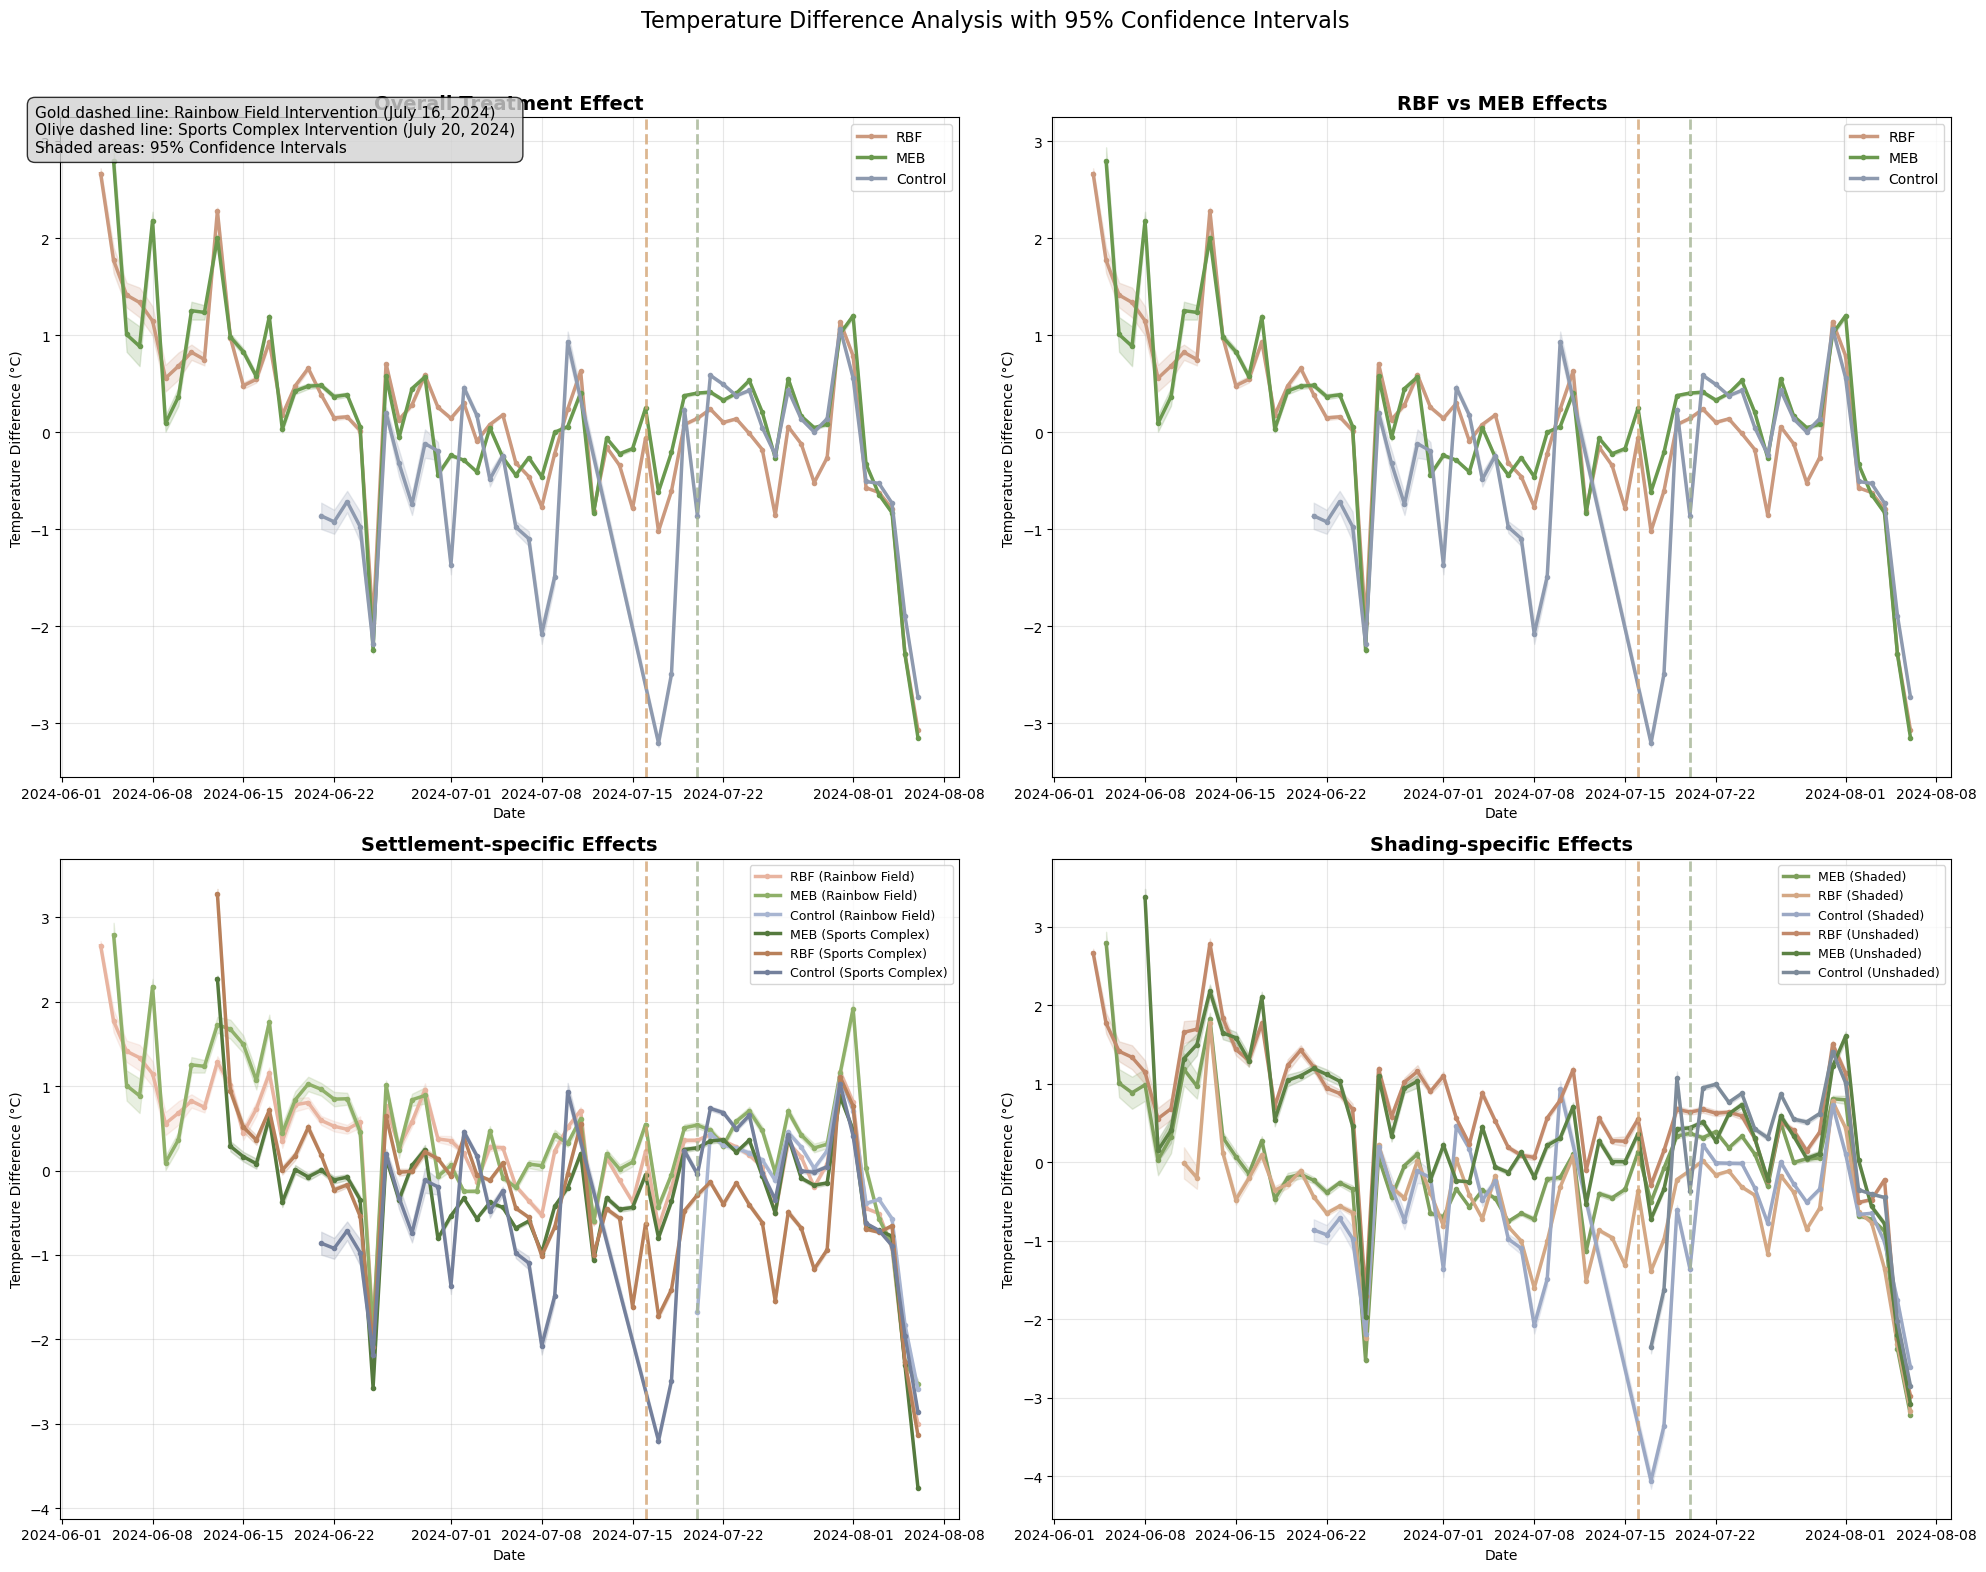


DATA VERIFICATION

Treatment assignment counts:
Treatment_Type
RBF        1037168
MEB         806099
Control     436613
Name: count, dtype: int64

Observations by settlement and treatment:
Treatment_Type  Control     MEB     RBF
Settlement                             
Rainbow Field    124557  267145  397503
Sports Complex   312056  538954  639665

Pre/Post period verification:
Post             False   True 
Treatment_Type                
Control          56834  379779
MEB             512579  293520
RBF             669738  367430

Intervention logic verification:
Rainbow Field: 391,273 pre, 397,932 post observations
Sports Complex: 847,878 pre, 642,797 post observations


In [7]:
# Parallel Trends Analysis with Confidence Intervals

# Convert Date to datetime for proper plotting
did_df['Date_dt'] = pd.to_datetime(did_df['Date'])

# Create treatment type variable
did_df['Treatment_Type'] = 'Control'
did_df.loc[did_df['RBF'] == True, 'Treatment_Type'] = 'RBF'
did_df.loc[did_df['MEB'] == True, 'Treatment_Type'] = 'MEB'

# Daily aggregation with confidence intervals
daily_avg = did_df.groupby(['Date_dt', 'Treatment_Type', 'Settlement', 'Shaded']).agg({
    'Temperature_Difference': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
daily_avg.columns = ['Date', 'Treatment_Type', 'Settlement', 'Shaded', 'Temp_Diff_Mean', 'Temp_Diff_Std', 'Count']

# Calculate 95% confidence intervals
daily_avg['SE'] = daily_avg['Temp_Diff_Std'] / np.sqrt(daily_avg['Count'])
daily_avg['CI_Lower'] = daily_avg['Temp_Diff_Mean'] - 1.96 * daily_avg['SE']
daily_avg['CI_Upper'] = daily_avg['Temp_Diff_Mean'] + 1.96 * daily_avg['SE']

print(f"Daily data shape: {daily_avg.shape}")
print(f"Date range: {daily_avg['Date'].min()} to {daily_avg['Date'].max()}")
print(f"Treatment types: {daily_avg['Treatment_Type'].unique()}")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Define elegant pastel color scheme for better differentiation
colors = {
    'Control': '#8E9AAF',    # Sophisticated blue-gray
    'RBF': '#CB997E',        # Warm terracotta 
    'MEB': '#6A994E'         # Sage green
}

# Settlement-specific color variations (lighter/darker shades)
settlement_colors = {
    ('Control', 'Rainbow Field'): '#A8B5D1',     # Lighter blue-gray
    ('Control', 'Sports Complex'): '#74809C',     # Darker blue-gray
    ('RBF', 'Rainbow Field'): '#E8B4A0',         # Lighter terracotta
    ('RBF', 'Sports Complex'): '#B8805A',        # Darker terracotta  
    ('MEB', 'Rainbow Field'): '#8FB069',         # Lighter sage
    ('MEB', 'Sports Complex'): '#557A3E'         # Darker sage
}

# Shading-specific color variations  
shading_colors = {
    ('Control', 'Shaded'): '#9BA8C4',           # Muted blue-gray
    ('Control', 'Unshaded'): '#7D8B9A',         # Deeper blue-gray
    ('RBF', 'Shaded'): '#D4A885',              # Muted terracotta
    ('RBF', 'Unshaded'): '#C2896B',            # Deeper terracotta
    ('MEB', 'Shaded'): '#7EA05C',              # Muted sage
    ('MEB', 'Unshaded'): '#5C8244'             # Deeper sage
}

# Panel 1: Overall Treatment Effect
overall_data = daily_avg.groupby(['Date', 'Treatment_Type']).agg({
    'Temp_Diff_Mean': 'mean',
    'Count': 'sum',
    'Temp_Diff_Std': lambda x: np.sqrt(np.sum(x**2)) / len(x)
}).reset_index()

overall_data['SE'] = overall_data['Temp_Diff_Std'] / np.sqrt(overall_data['Count'])
overall_data['CI_Lower'] = overall_data['Temp_Diff_Mean'] - 1.96 * overall_data['SE']
overall_data['CI_Upper'] = overall_data['Temp_Diff_Mean'] + 1.96 * overall_data['SE']

for treatment in overall_data['Treatment_Type'].unique():
    data = overall_data[overall_data['Treatment_Type'] == treatment]
    ax1.plot(data['Date'], data['Temp_Diff_Mean'], 
            color=colors[treatment], linewidth=2.5, label=treatment, marker='o', markersize=3)
    ax1.fill_between(data['Date'], data['CI_Lower'], data['CI_Upper'],
                    color=colors[treatment], alpha=0.2)

ax1.axvline(x=rainbow_intervention_date, color='#D4A574', linestyle='--', alpha=0.8, linewidth=2)  # Elegant gold
ax1.axvline(x=sports_intervention_date, color='#A4B494', linestyle='--', alpha=0.8, linewidth=2)   # Elegant olive
ax1.set_title('Overall Treatment Effect', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature Difference (°C)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: RBF vs MEB Effects
for treatment in overall_data['Treatment_Type'].unique():
    data = overall_data[overall_data['Treatment_Type'] == treatment]
    ax2.plot(data['Date'], data['Temp_Diff_Mean'], 
            color=colors[treatment], linewidth=2.5, label=treatment, marker='o', markersize=3)
    ax2.fill_between(data['Date'], data['CI_Lower'], data['CI_Upper'],
                    color=colors[treatment], alpha=0.2)

ax2.axvline(x=rainbow_intervention_date, color='#D4A574', linestyle='--', alpha=0.8, linewidth=2)  # Elegant gold
ax2.axvline(x=sports_intervention_date, color='#A4B494', linestyle='--', alpha=0.8, linewidth=2)   # Elegant olive
ax2.set_title('RBF vs MEB Effects', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature Difference (°C)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Settlement-specific Effects
for settlement in ['Rainbow Field', 'Sports Complex']:
    settlement_data = daily_avg[daily_avg['Settlement'] == settlement]
    if not settlement_data.empty:
        settlement_summary = settlement_data.groupby(['Date', 'Treatment_Type']).agg({
            'Temp_Diff_Mean': 'mean',
            'Count': 'sum',
            'Temp_Diff_Std': lambda x: np.sqrt(np.sum(x**2)) / len(x)
        }).reset_index()
        
        settlement_summary['SE'] = settlement_summary['Temp_Diff_Std'] / np.sqrt(settlement_summary['Count'])
        settlement_summary['CI_Lower'] = settlement_summary['Temp_Diff_Mean'] - 1.96 * settlement_summary['SE']
        settlement_summary['CI_Upper'] = settlement_summary['Temp_Diff_Mean'] + 1.96 * settlement_summary['SE']
        
        for treatment in settlement_summary['Treatment_Type'].unique():
            data = settlement_summary[settlement_summary['Treatment_Type'] == treatment]
            color_key = (treatment, settlement)
            line_color = settlement_colors.get(color_key, colors[treatment])
            ax3.plot(data['Date'], data['Temp_Diff_Mean'], 
                    color=line_color, linestyle='-',
                    label=f'{treatment} ({settlement})', linewidth=2.5, marker='o', markersize=3)
            ax3.fill_between(data['Date'], data['CI_Lower'], data['CI_Upper'],
                            color=line_color, alpha=0.2)

ax3.axvline(x=rainbow_intervention_date, color='#D4A574', linestyle='--', alpha=0.8, linewidth=2)  # Elegant gold
ax3.axvline(x=sports_intervention_date, color='#A4B494', linestyle='--', alpha=0.8, linewidth=2)   # Elegant olive
ax3.set_title('Settlement-specific Effects', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature Difference (°C)')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Panel 4: Shading-specific Effects
for shaded in [True, False]:
    shade_label = 'Shaded' if shaded else 'Unshaded'
    shading_data = daily_avg[daily_avg['Shaded'] == shaded]
    if not shading_data.empty:
        shade_summary = shading_data.groupby(['Date', 'Treatment_Type']).agg({
            'Temp_Diff_Mean': 'mean',
            'Count': 'sum',
            'Temp_Diff_Std': lambda x: np.sqrt(np.sum(x**2)) / len(x)
        }).reset_index()
        
        shade_summary['SE'] = shade_summary['Temp_Diff_Std'] / np.sqrt(shade_summary['Count'])
        shade_summary['CI_Lower'] = shade_summary['Temp_Diff_Mean'] - 1.96 * shade_summary['SE']
        shade_summary['CI_Upper'] = shade_summary['Temp_Diff_Mean'] + 1.96 * shade_summary['SE']
        
        for treatment in shade_summary['Treatment_Type'].unique():
            data = shade_summary[shade_summary['Treatment_Type'] == treatment]
            color_key = (treatment, shade_label)
            line_color = shading_colors.get(color_key, colors[treatment])
            ax4.plot(data['Date'], data['Temp_Diff_Mean'], 
                    color=line_color, linestyle='-',
                    label=f'{treatment} ({shade_label})', linewidth=2.5, marker='o', markersize=3)
            ax4.fill_between(data['Date'], data['CI_Lower'], data['CI_Upper'],
                            color=line_color, alpha=0.2)

ax4.axvline(x=rainbow_intervention_date, color='#D4A574', linestyle='--', alpha=0.8, linewidth=2)  # Elegant gold
ax4.axvline(x=sports_intervention_date, color='#A4B494', linestyle='--', alpha=0.8, linewidth=2)   # Elegant olive
ax4.set_title('Shading-specific Effects', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature Difference (°C)')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Add titles and legends
fig.suptitle('Temperature Difference Analysis with 95% Confidence Intervals', fontsize=16, y=0.98)

# Create intervention legend in upper portion to avoid x-axis overlap
legend_text = ('Gold dashed line: Rainbow Field Intervention (July 16, 2024)\n'
               'Olive dashed line: Sports Complex Intervention (July 20, 2024)\n'
               'Shaded areas: 95% Confidence Intervals')
fig.text(0.02, 0.92, legend_text, fontsize=11, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Data verification and summary statistics
print("\n" + "="*60)
print("DATA VERIFICATION")
print("="*60)

print("\nTreatment assignment counts:")
print(did_df['Treatment_Type'].value_counts())

print("\nObservations by settlement and treatment:")
print(did_df.groupby(['Settlement', 'Treatment_Type']).size().unstack(fill_value=0))

print("\nPre/Post period verification:")
print(did_df.groupby(['Treatment_Type', 'Post']).size().unstack(fill_value=0))

print("\nIntervention logic verification:")
for settlement in ['Rainbow Field', 'Sports Complex']:
    intervention_date = rainbow_intervention_date if settlement == 'Rainbow Field' else sports_intervention_date
    settlement_data = did_df[did_df['Settlement'] == settlement]
    
    pre_count = settlement_data[settlement_data['Date_dt'] < intervention_date].shape[0]
    post_count = settlement_data[settlement_data['Date_dt'] >= intervention_date].shape[0]
    
    print(f"{settlement}: {pre_count:,} pre, {post_count:,} post observations")


# Prepare Data

In [8]:
# Prepare data for regression analysis
print("Preparing regression data...")

# First, create a copy of the data for regression
regression_data = did_df.copy()

# Convert boolean columns to numeric
regression_data['Post'] = regression_data['Post'].astype(int)
regression_data['Treatment'] = regression_data['Treatment'].astype(int)
regression_data['Shaded'] = regression_data['Shaded'].astype(int)
regression_data['RBF'] = regression_data['RBF'].astype(int)
regression_data['MEB'] = regression_data['MEB'].astype(int)
regression_data['Daytime'] = regression_data['Daytime'].astype(int)

# Create numeric columns
regression_data['Settlement_num'] = (regression_data['Settlement'] == 'Sports Complex').astype(int)

# Ensure Temperature_Difference is numeric
regression_data['Temperature_Difference'] = pd.to_numeric(regression_data['Temperature_Difference'], errors='coerce')

# Create interaction terms
regression_data['Post_Treatment'] = regression_data['Post'] * regression_data['Treatment']
regression_data['Post_RBF'] = regression_data['Post'] * regression_data['RBF']
regression_data['Post_MEB'] = regression_data['Post'] * regression_data['MEB']
regression_data['Post_Treatment_Shaded'] = regression_data['Post_Treatment'] * regression_data['Shaded']
regression_data['Post_Treatment_Settlement'] = regression_data['Post_Treatment'] * regression_data['Settlement_num']
regression_data['Post_Treatment_Daytime'] = regression_data['Post_Treatment'] * regression_data['Daytime']

# Drop any rows with NaN values
regression_data = regression_data.dropna(subset=['Temperature_Difference'])

# Print data preparation summary
print("\nData preparation summary:")
print(f"Original observations: {len(did_df)}")
print(f"Observations after cleaning: {len(regression_data)}")
print("\nVariable statistics:")
print(regression_data[['Temperature_Difference', 'Post', 'Treatment', 'Post_Treatment']].describe())

# Dictionary to store regression results
models = {}

Preparing regression data...

Data preparation summary:
Original observations: 2279880
Observations after cleaning: 2279880

Variable statistics:
       Temperature_Difference          Post     Treatment  Post_Treatment
count            2.279880e+06  2.279880e+06  2.279880e+06    2.279880e+06
mean            -1.709633e-01  4.564841e-01  8.084930e-01    2.899056e-01
std              2.757393e+00  4.981029e-01  3.934872e-01    4.537185e-01
min             -1.210000e+01  0.000000e+00  0.000000e+00    0.000000e+00
25%             -1.700000e+00  0.000000e+00  1.000000e+00    0.000000e+00
50%             -2.000000e-01  0.000000e+00  1.000000e+00    0.000000e+00
75%              1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00
max              2.551833e+01  1.000000e+00  1.000000e+00    1.000000e+00


In [9]:
# Checks - Check Post assignment by Settlement and Treatment
print("\n" + "="*60)
print("CRITICAL VERIFICATION - Post Assignment Logic")
print("="*60)

# Check Post assignment by Settlement
print("\nPost assignment by Settlement:")
settlement_post = regression_data.groupby(['Settlement', 'Post']).size().unstack(fill_value=0)
print(settlement_post)
print(f"Rainbow Field Post %: {settlement_post.loc['Rainbow Field', 1] / settlement_post.loc['Rainbow Field'].sum() * 100:.1f}%")
print(f"Sports Complex Post %: {settlement_post.loc['Sports Complex', 1] / settlement_post.loc['Sports Complex'].sum() * 100:.1f}%")

# Check Post assignment by Treatment Type and Settlement
print("\nPost assignment by Treatment and Settlement:")
detailed_check = regression_data.groupby(['Settlement', 'Treatment_Type', 'Post']).size().unstack(fill_value=0)
print(detailed_check)

# Verify intervention date logic
print("\nIntervention date verification:")
print(f"Rainbow Field intervention: {rainbow_intervention_date}")
print(f"Sports Complex intervention: {sports_intervention_date}")

# Check actual date ranges for each settlement
for settlement in ['Rainbow Field', 'Sports Complex']:
    settlement_data = regression_data[regression_data['Settlement'] == settlement]
    pre_dates = settlement_data[settlement_data['Post'] == 0]['Date_dt']
    post_dates = settlement_data[settlement_data['Post'] == 1]['Date_dt']
    
    print(f"\n{settlement}:")
    print(f"  Pre-period: {pre_dates.min()} to {pre_dates.max()}")
    print(f"  Post-period: {post_dates.min()} to {post_dates.max()}")
    
    intervention_date = rainbow_intervention_date if settlement == 'Rainbow Field' else sports_intervention_date
    
    # Check if there are any post observations before intervention date
    wrong_post = settlement_data[(settlement_data['Post'] == 1) & (settlement_data['Date_dt'] < intervention_date)]
    # Check if there are any pre observations after intervention date
    wrong_pre = settlement_data[(settlement_data['Post'] == 0) & (settlement_data['Date_dt'] >= intervention_date)]
    
    print(f"  Wrong post assignments (post=1 before intervention): {len(wrong_post)}")
    print(f"  Wrong pre assignments (post=0 after intervention): {len(wrong_pre)}")

# Temperature difference verification by treatment
print(f"\n" + "="*60)
print("TEMPERATURE DIFFERENCE VERIFICATION")
print("="*60)
temp_by_treatment = regression_data.groupby(['Treatment_Type', 'Post'])['Temperature_Difference'].agg(['mean', 'std', 'count'])
print(temp_by_treatment.round(3))


CRITICAL VERIFICATION - Post Assignment Logic

Post assignment by Settlement:
Post                 0       1
Settlement                    
Rainbow Field   391273  397932
Sports Complex  847878  642797
Rainbow Field Post %: 50.4%
Sports Complex Post %: 43.1%

Post assignment by Treatment and Settlement:
Post                                0       1
Settlement     Treatment_Type                
Rainbow Field  Control              0  124557
               MEB             148813  118332
               RBF             242460  155043
Sports Complex Control          56834  255222
               MEB             363766  175188
               RBF             427278  212387

Intervention date verification:
Rainbow Field intervention: 2024-07-16 00:00:00
Sports Complex intervention: 2024-07-20 00:00:00

Rainbow Field:
  Pre-period: 2024-06-04 00:00:00 to 2024-07-15 00:00:00
  Post-period: 2024-07-16 00:00:00 to 2024-08-06 00:00:00
  Wrong post assignments (post=1 before intervention): 0
  Wrong 

In [10]:

# Verification Check: Check Post assignment by Settlement and Treatment
print("\n" + "="*60)
print("Verification Check - Post Assignment Logic")
print("="*60)

# Check Post assignment by Settlement
print("\nPost assignment by Settlement:")
settlement_post = regression_data.groupby(['Settlement', 'Post']).size().unstack(fill_value=0)
print(settlement_post)
print(f"Rainbow Field Post %: {settlement_post.loc['Rainbow Field', 1] / settlement_post.loc['Rainbow Field'].sum() * 100:.1f}%")
print(f"Sports Complex Post %: {settlement_post.loc['Sports Complex', 1] / settlement_post.loc['Sports Complex'].sum() * 100:.1f}%")

# Check Post assignment by Treatment Type and Settlement
print("\nPost assignment by Treatment and Settlement:")
detailed_check = regression_data.groupby(['Settlement', 'Treatment_Type', 'Post']).size().unstack(fill_value=0)
print(detailed_check)

# Verify intervention date logic
print("\nIntervention date verification:")
print(f"Rainbow Field intervention: {rainbow_intervention_date}")
print(f"Sports Complex intervention: {sports_intervention_date}")

# Check actual date ranges for each settlement
for settlement in ['Rainbow Field', 'Sports Complex']:
    settlement_data = regression_data[regression_data['Settlement'] == settlement]
    pre_dates = settlement_data[settlement_data['Post'] == 0]['Date_dt']
    post_dates = settlement_data[settlement_data['Post'] == 1]['Date_dt']
    
    print(f"\n{settlement}:")
    print(f"  Pre-period: {pre_dates.min()} to {pre_dates.max()}")
    print(f"  Post-period: {post_dates.min()} to {post_dates.max()}")
    
    intervention_date = rainbow_intervention_date if settlement == 'Rainbow Field' else sports_intervention_date
    
    # Check if there are any post observations before intervention date
    wrong_post = settlement_data[(settlement_data['Post'] == 1) & (settlement_data['Date_dt'] < intervention_date)]
    # Check if there are any pre observations after intervention date
    wrong_pre = settlement_data[(settlement_data['Post'] == 0) & (settlement_data['Date_dt'] >= intervention_date)]
    
    print(f"  Wrong post assignments (post=1 before intervention): {len(wrong_post)}")
    print(f"  Wrong pre assignments (post=0 after intervention): {len(wrong_pre)}")

# Temperature difference verification by treatment
print(f"\n" + "="*60)
print("TEMPERATURE DIFFERENCE VERIFICATION")
print("="*60)
temp_by_treatment = regression_data.groupby(['Treatment_Type', 'Post'])['Temperature_Difference'].agg(['mean', 'std', 'count'])
print(temp_by_treatment.round(3))


Verification Check - Post Assignment Logic

Post assignment by Settlement:
Post                 0       1
Settlement                    
Rainbow Field   391273  397932
Sports Complex  847878  642797
Rainbow Field Post %: 50.4%
Sports Complex Post %: 43.1%

Post assignment by Treatment and Settlement:
Post                                0       1
Settlement     Treatment_Type                
Rainbow Field  Control              0  124557
               MEB             148813  118332
               RBF             242460  155043
Sports Complex Control          56834  255222
               MEB             363766  175188
               RBF             427278  212387

Intervention date verification:
Rainbow Field intervention: 2024-07-16 00:00:00
Sports Complex intervention: 2024-07-20 00:00:00

Rainbow Field:
  Pre-period: 2024-06-04 00:00:00 to 2024-07-15 00:00:00
  Post-period: 2024-07-16 00:00:00 to 2024-08-06 00:00:00
  Wrong post assignments (post=1 before intervention): 0
  Wrong pre

# Difference-in-Differences Regression Models for Informal Settlements Cooling Study

Below are the comprehensive mathematical formulations for each regression model in our analysis:

## 1. Basic DiD Model

$$Y_{it} = \beta_0 + \beta_1 \text{Post}_t + \beta_2 \text{Treatment}_i + \beta_3 (\text{Post}_t \times \text{Treatment}_i) + \varepsilon_{it}$$

**Where:**
- $Y_{it}$ is the temperature difference between indoor and outdoor temperatures (°C) for unit $i$ at time $t$
- $\beta_0$ is the constant term representing the baseline temperature difference for control units in the pre-intervention period
- $\text{Post}_t$ is a binary indicator equal to 1 for observations after the intervention date, 0 otherwise
- $\text{Treatment}_i$ is a binary indicator equal to 1 for structures receiving any thermal intervention (RBF or MEB), 0 for control structures
- $(\text{Post}_t \times \text{Treatment}_i)$ is the interaction term representing the difference-in-differences effect
- $\varepsilon_{it}$ is the error term capturing unobserved factors
- $\beta_1$ captures secular trends affecting all structures in the post-intervention period
- $\beta_2$ reflects pre-existing differences between treatment and control groups
- $\beta_3$ is the causal effect of the intervention (the parameter of primary interest)

## 2. Separate Interventions Model

$$Y_{it} = \beta_0 + \beta_1 \text{Post}_t + \beta_2 \text{RBF}_i + \beta_3 \text{MEB}_i + \beta_4 (\text{Post}_t \times \text{RBF}_i) + \beta_5 (\text{Post}_t \times \text{MEB}_i) + \varepsilon_{it}$$

**Where:**
- $Y_{it}$ is the temperature difference between indoor and outdoor temperatures (°C) for unit $i$ at time $t$
- $\beta_0$ is the constant term representing the baseline temperature difference for control units in the pre-intervention period
- $\text{Post}_t$ is a binary indicator equal to 1 for observations after the intervention date, 0 otherwise
- $\text{RBF}_i$ is a binary indicator equal to 1 for units treated with Radiant Barrier Foil, 0 otherwise
- $\text{MEB}_i$ is a binary indicator equal to 1 for units treated with Mylar Emergency Blankets, 0 otherwise
- $(\text{Post}_t \times \text{RBF}_i)$ is the interaction term representing the DiD effect for RBF interventions
- $(\text{Post}_t \times \text{MEB}_i)$ is the interaction term representing the DiD effect for MEB interventions
- $\varepsilon_{it}$ is the error term capturing unobserved factors
- $\beta_1$ captures secular trends affecting all structures in the post-intervention period
- $\beta_2$ reflects pre-existing differences between RBF and control groups
- $\beta_3$ reflects pre-existing differences between MEB and control groups
- $\beta_4$ is the causal effect of RBF intervention (cooling effect in °C)
- $\beta_5$ is the causal effect of MEB intervention (cooling effect in °C)

## 3. Controls Model

$$\begin{align}
Y_{it} = \beta_0 &+ \beta_1 \text{Post}_t + \beta_2 \text{RBF}_i + \beta_3 \text{MEB}_i \\
&+ \beta_4 (\text{Post}_t \times \text{RBF}_i) + \beta_5 (\text{Post}_t \times \text{MEB}_i) \\
&+ \beta_6 \text{Shaded}_i + \beta_7 \text{Settlement}_i + \beta_8 \text{Daytime}_t + \varepsilon_{it}
\end{align}$$

**Where:**
- $Y_{it}$ is the temperature difference between indoor and outdoor temperatures (°C) for unit $i$ at time $t$
- $\beta_0$ is the constant term representing the baseline temperature difference for unshaded control units in Rainbow Field during nighttime in the pre-intervention period
- $\text{Post}_t$ is a binary indicator equal to 1 for observations after the intervention date, 0 otherwise
- $\text{RBF}_i$ is a binary indicator equal to 1 for units treated with Radiant Barrier Foil, 0 otherwise
- $\text{MEB}_i$ is a binary indicator equal to 1 for units treated with Mylar Emergency Blankets, 0 otherwise
- $(\text{Post}_t \times \text{RBF}_i)$ is the interaction term representing the DiD effect for RBF interventions
- $(\text{Post}_t \times \text{MEB}_i)$ is the interaction term representing the DiD effect for MEB interventions
- $\text{Shaded}_i$ is a binary indicator equal to 1 for structures with existing shade coverage, 0 for unshaded structures
- $\text{Settlement}_i$ is a binary indicator equal to 1 for Sports Complex settlement, 0 for Rainbow Field settlement
- $\text{Daytime}_t$ is a binary indicator equal to 1 for observations during daylight hours (6:00-19:00), 0 for nighttime observations
- $\varepsilon_{it}$ is the error term capturing unobserved factors
- $\beta_1$ captures secular trends affecting all structures in the post-intervention period
- $\beta_2, \beta_3$ reflect pre-existing differences between treatment technologies and control groups
- $\beta_4, \beta_5$ are the causal effects of RBF and MEB interventions respectively, controlling for observable confounders
- $\beta_6$ captures the effect of existing shade on temperature regulation
- $\beta_7$ captures settlement-specific temperature differences
- $\beta_8$ captures diurnal temperature variation patterns

## 4. Heterogeneous Effects Model

$$\begin{align}
Y_{it} = \beta_0 &+ \beta_1 \text{Post}_t + \beta_2 \text{RBF}_i + \beta_3 \text{MEB}_i \\
&+ \beta_4 (\text{Post}_t \times \text{RBF}_i) + \beta_5 (\text{Post}_t \times \text{MEB}_i) \\
&+ \beta_6 \text{Shaded}_i + \beta_7 \text{Settlement}_i + \beta_8 \text{Daytime}_t \\
&+ \beta_9 (\text{Post}_t \times \text{RBF}_i \times \text{Shaded}_i) \\
&+ \beta_{10} (\text{Post}_t \times \text{MEB}_i \times \text{Shaded}_i) \\
&+ \beta_{11} (\text{Post}_t \times \text{RBF}_i \times \text{Daytime}_t) \\
&+ \beta_{12} (\text{Post}_t \times \text{MEB}_i \times \text{Daytime}_t) + \varepsilon_{it}
\end{align}$$

**Where:**
- $Y_{it}$ is the temperature difference between indoor and outdoor temperatures (°C) for unit $i$ at time $t$
- $\beta_0$ is the constant term representing the baseline temperature difference for unshaded control units in Rainbow Field during nighttime in the pre-intervention period
- $\text{Post}_t$ is a binary indicator equal to 1 for observations after the intervention date, 0 otherwise
- $\text{RBF}_i$ is a binary indicator equal to 1 for units treated with Radiant Barrier Foil, 0 otherwise
- $\text{MEB}_i$ is a binary indicator equal to 1 for units treated with Mylar Emergency Blankets, 0 otherwise
- $(\text{Post}_t \times \text{RBF}_i)$ is the interaction term representing the DiD effect for RBF interventions in unshaded conditions during nighttime (reference category)
- $(\text{Post}_t \times \text{MEB}_i)$ is the interaction term representing the DiD effect for MEB interventions in unshaded conditions during nighttime (reference category)
- $\text{Shaded}_i$ is a binary indicator equal to 1 for structures with existing shade coverage, 0 for unshaded structures
- $\text{Settlement}_i$ is a binary indicator equal to 1 for Sports Complex settlement, 0 for Rainbow Field settlement
- $\text{Daytime}_t$ is a binary indicator equal to 1 for observations during daylight hours (6:00-19:00), 0 for nighttime observations
- $(\text{Post}_t \times \text{RBF}_i \times \text{Shaded}_i)$ is the three-way interaction capturing differential RBF effectiveness in shaded vs. unshaded conditions
- $(\text{Post}_t \times \text{MEB}_i \times \text{Shaded}_i)$ is the three-way interaction capturing differential MEB effectiveness in shaded vs. unshaded conditions
- $(\text{Post}_t \times \text{RBF}_i \times \text{Daytime}_t)$ is the three-way interaction capturing differential RBF effectiveness during daytime vs. nighttime
- $(\text{Post}_t \times \text{MEB}_i \times \text{Daytime}_t)$ is the three-way interaction capturing differential MEB effectiveness during daytime vs. nighttime
- $\varepsilon_{it}$ is the error term capturing unobserved factors
- $\beta_1$ captures secular trends affecting all structures in the post-intervention period
- $\beta_2, \beta_3$ reflect pre-existing differences between treatment technologies and control groups
- $\beta_4$ is the causal effect of RBF intervention in unshaded conditions during nighttime (baseline reference)
- $\beta_5$ is the causal effect of MEB intervention in unshaded conditions during nighttime (baseline reference)
- $\beta_6$ captures the effect of existing shade on temperature regulation
- $\beta_7$ captures settlement-specific temperature differences
- $\beta_8$ captures diurnal temperature variation patterns
- $\beta_9$ represents the differential RBF effect in shaded vs. unshaded structures (attenuation/amplification factor)
- $\beta_{10}$ represents the differential MEB effect in shaded vs. unshaded structures (attenuation/amplification factor)
- $\beta_{11}$ represents the differential RBF effect during daytime vs. nighttime (amplification factor for solar radiation hours)
- $\beta_{12}$ represents the differential MEB effect during daytime vs. nighttime (amplification factor for solar radiation hours)

## Key Treatment Effects Interpretation:

**From Model 4 - Four Distinct Treatment Conditions:**
- **RBF in Unshaded, Nighttime**: $\beta_4$ (baseline reference category)
- **RBF in Shaded, Nighttime**: $\beta_4 + \beta_9$ 
- **RBF in Unshaded, Daytime**: $\beta_4 + \beta_{11}$
- **RBF in Shaded, Daytime**: $\beta_4 + \beta_9 + \beta_{11}$ (no four-way interaction assumed)
- **MEB in Unshaded, Nighttime**: $\beta_5$ (baseline reference category)
- **MEB in Shaded, Nighttime**: $\beta_5 + \beta_{10}$
- **MEB in Unshaded, Daytime**: $\beta_5 + \beta_{12}$
- **MEB in Shaded, Daytime**: $\beta_5 + \beta_{10} + \beta_{12}$ (no four-way interaction assumed)

**Scientific Interpretation:**
Both technologies are expected to show enhanced effectiveness during daytime hours when solar radiation is present (positive $\beta_{11}, \beta_{12}$), but reduced effectiveness in shaded environments where direct solar exposure is limited (negative $\beta_9, \beta_{10}$). This pattern aligns with the physical mechanism of solar radiation reflection that underlies both RBF and MEB cooling technologies.

## Statistical Specification Notes:

- All models employ cluster-robust standard errors at the logger level to account for spatial and temporal correlation
- The staggered intervention design (Rainbow Field: July 16, Sports Complex: July 20) provides additional identification variation
- Temperature difference is calculated as indoor minus outdoor temperature, where negative values indicate cooling effects
- The large sample size (N = 2.28 million observations) provides exceptional statistical power for detecting small effect sizes 

In [11]:
# Prepare data for regression analysis
print("Preparing regression data...")

# First, create a copy of the data for regression
regression_data = did_df.copy()

# Convert boolean columns to numeric
regression_data['Post'] = regression_data['Post'].astype(int)
regression_data['Treatment'] = regression_data['Treatment'].astype(int)
regression_data['Shaded'] = regression_data['Shaded'].astype(int)
regression_data['RBF'] = regression_data['RBF'].astype(int)
regression_data['MEB'] = regression_data['MEB'].astype(int)
regression_data['Daytime'] = regression_data['Daytime'].astype(int)

# Create numeric columns
regression_data['Settlement_num'] = (regression_data['Settlement'] == 'Sports Complex').astype(int)

# Ensure Temperature_Difference is numeric
regression_data['Temperature_Difference'] = pd.to_numeric(regression_data['Temperature_Difference'], errors='coerce')

# Create interaction terms
regression_data['Post_Treatment'] = regression_data['Post'] * regression_data['Treatment']
regression_data['Post_RBF'] = regression_data['Post'] * regression_data['RBF']
regression_data['Post_MEB'] = regression_data['Post'] * regression_data['MEB']
# Separate RBF and MEB shading interactions for Model 4
regression_data['Post_RBF_Shaded'] = regression_data['Post_RBF'] * regression_data['Shaded']
regression_data['Post_MEB_Shaded'] = regression_data['Post_MEB'] * regression_data['Shaded']
# Settlement and daytime interactions for Model 4
regression_data['Post_RBF_Settlement'] = regression_data['Post_RBF'] * regression_data['Settlement_num']
regression_data['Post_MEB_Settlement'] = regression_data['Post_MEB'] * regression_data['Settlement_num']
regression_data['Post_RBF_Daytime'] = regression_data['Post_RBF'] * regression_data['Daytime']
regression_data['Post_MEB_Daytime'] = regression_data['Post_MEB'] * regression_data['Daytime']

# Drop any rows with NaN values
regression_data = regression_data.dropna(subset=['Temperature_Difference'])

# Print data preparation summary
print("\nData preparation summary:")
print(f"Original observations: {len(did_df)}")
print(f"Observations after cleaning: {len(regression_data)}")
print("\nVariable statistics:")
print(regression_data[['Temperature_Difference', 'Post', 'Treatment', 'Post_Treatment']].describe())

# Dictionary to store regression results
models = {}

# 1. Basic DiD Model
print("\nRunning Basic DiD Model...")
X_basic = sm.add_constant(regression_data[['Post', 'Treatment', 'Post_Treatment']])
models['basic'] = sm.OLS(regression_data['Temperature_Difference'], X_basic).fit(
    cov_type='cluster', 
    cov_kwds={'groups': regression_data['Logger']}
)

# 2. Separate RBF and MEB Effects
print("Running Separate RBF/MEB Model...")
X_separate = sm.add_constant(regression_data[['Post', 'RBF', 'MEB', 'Post_RBF', 'Post_MEB']])
models['separate'] = sm.OLS(regression_data['Temperature_Difference'], X_separate).fit(
    cov_type='cluster', 
    cov_kwds={'groups': regression_data['Logger']}
)

# 3. Model with Controls 
print("Running Model with Controls (Separate RBF/MEB)...")
X_controls = sm.add_constant(regression_data[[
    'Post', 'RBF', 'MEB', 'Post_RBF', 'Post_MEB',
    'Shaded', 'Settlement_num', 'Daytime'
]])
models['controls'] = sm.OLS(regression_data['Temperature_Difference'], X_controls).fit(
    cov_type='cluster', 
    cov_kwds={'groups': regression_data['Logger']}
)

# 4. Full Heterogeneous Effects Model (Shading and Daytime Interactions)
print("Running Heterogeneous Effects Model (Shading and Daytime interactions)...")
X_hetero = sm.add_constant(regression_data[[
    'Post', 'RBF', 'MEB', 'Post_RBF', 'Post_MEB',
    'Shaded', 'Settlement_num', 'Daytime',
    'Post_RBF_Shaded', 'Post_MEB_Shaded', 
    'Post_RBF_Daytime', 'Post_MEB_Daytime'
]])
models['hetero'] = sm.OLS(regression_data['Temperature_Difference'], X_hetero).fit(
    cov_type='cluster', 
    cov_kwds={'groups': regression_data['Logger']}
)

# Print results function (same as before)
def print_model_results(model, title):
    print("\n" + "="*80)
    print(f"\n{title}")
    print("="*80)
    
    # Print key coefficients with statistical significance
    coef = model.params
    conf = model.conf_int()
    std_err = model.bse
    t_stat = model.tvalues
    p_val = model.pvalues
    
    results_df = pd.DataFrame({
        'Coefficient': coef,
        'Std Error': std_err,
        't-stat': t_stat,
        'P-value': p_val,
        'CI Lower': conf[0],
        'CI Upper': conf[1]
    })
    
    # Add stars for significance
    def add_stars(p_value):
        if p_value < 0.01:
            return '***'
        elif p_value < 0.05:
            return '**'
        elif p_value < 0.1:
            return '*'
        return ''
    
    results_df['Significance'] = results_df['P-value'].apply(add_stars)
    
    print("\nRegression Results:")
    print(results_df.round(4))
    
    # Print model statistics
    print("\nModel Statistics:")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print(f"F-statistic: {model.fvalue:.4f}")
    print(f"Number of observations: {model.nobs}")

# Print results for all models
print_model_results(models['basic'], "Basic DiD Model")
print_model_results(models['separate'], "Separate RBF and MEB Effects Model")
print_model_results(models['controls'], "Model with Controls (Separate RBF/MEB)")
print_model_results(models['hetero'], "Heterogeneous Effects Model (Shading and Daytime Interactions)")

# Calculate and print treatment effects
print("\n" + "="*80)
print("\nTreatment Effect Estimates:")
print("="*80)

# Basic Treatment Effect
ate = models['basic'].params['Post_Treatment']
ate_se = models['basic'].bse['Post_Treatment']
print(f"\nOverall Average Treatment Effect: {ate:.3f}°C (SE: {ate_se:.3f})")

# Separate RBF and MEB Effects
rbf_effect = models['separate'].params['Post_RBF']
rbf_se = models['separate'].bse['Post_RBF']
meb_effect = models['separate'].params['Post_MEB']
meb_se = models['separate'].bse['Post_MEB']
print(f"RBF Effect: {rbf_effect:.3f}°C (SE: {rbf_se:.3f})")
print(f"MEB Effect: {meb_effect:.3f}°C (SE: {meb_se:.3f})")

# Heterogeneous Effects (Updated - Shading and Daytime Interactions)
rbf_base_effect = models['hetero'].params['Post_RBF']
meb_base_effect = models['hetero'].params['Post_MEB']
rbf_shaded_interaction = models['hetero'].params['Post_RBF_Shaded']
meb_shaded_interaction = models['hetero'].params['Post_MEB_Shaded']
rbf_daytime_interaction = models['hetero'].params['Post_RBF_Daytime']
meb_daytime_interaction = models['hetero'].params['Post_MEB_Daytime']

print("\nHeterogeneous Treatment Effects:")
print("\n--- RBF Effects ---")
print(f"RBF Base Effect (Unshaded, Nighttime): {rbf_base_effect:.3f}°C")
print(f"RBF Additional Effect of Shading: {rbf_shaded_interaction:.3f}°C")
print(f"RBF Additional Effect during Daytime: {rbf_daytime_interaction:.3f}°C")

print("\n--- MEB Effects ---")
print(f"MEB Base Effect (Unshaded, Nighttime): {meb_base_effect:.3f}°C")
print(f"MEB Additional Effect of Shading: {meb_shaded_interaction:.3f}°C")
print(f"MEB Additional Effect during Daytime: {meb_daytime_interaction:.3f}°C")

print("\n--- Calculated Effects in Four Key Conditions ---")
print("RBF Effects:")
print(f"  Unshaded, Nighttime: {rbf_base_effect:.3f}°C")
print(f"  Shaded, Nighttime: {rbf_base_effect + rbf_shaded_interaction:.3f}°C")
print(f"  Unshaded, Daytime: {rbf_base_effect + rbf_daytime_interaction:.3f}°C")
print(f"  Shaded, Daytime: {rbf_base_effect + rbf_shaded_interaction + rbf_daytime_interaction:.3f}°C")

print("MEB Effects:")
print(f"  Unshaded, Nighttime: {meb_base_effect:.3f}°C")
print(f"  Shaded, Nighttime: {meb_base_effect + meb_shaded_interaction:.3f}°C")
print(f"  Unshaded, Daytime: {meb_base_effect + meb_daytime_interaction:.3f}°C")
print(f"  Shaded, Daytime: {meb_base_effect + meb_shaded_interaction + meb_daytime_interaction:.3f}°C")

# Save results to a file
with open('did_regression_results.txt', 'w') as f:
    for model_name, model in models.items():
        f.write(f"\n{model_name.upper()} MODEL RESULTS\n")
        f.write("="*80 + "\n")
        f.write(model.summary().as_text())
        f.write("\n\n")

print("\nDetailed results have been saved to 'did_regression_results.txt'")

Preparing regression data...

Data preparation summary:
Original observations: 2279880
Observations after cleaning: 2279880

Variable statistics:
       Temperature_Difference          Post     Treatment  Post_Treatment
count            2.279880e+06  2.279880e+06  2.279880e+06    2.279880e+06
mean            -1.709633e-01  4.564841e-01  8.084930e-01    2.899056e-01
std              2.757393e+00  4.981029e-01  3.934872e-01    4.537185e-01
min             -1.210000e+01  0.000000e+00  0.000000e+00    0.000000e+00
25%             -1.700000e+00  0.000000e+00  1.000000e+00    0.000000e+00
50%             -2.000000e-01  0.000000e+00  1.000000e+00    0.000000e+00
75%              1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00
max              2.551833e+01  1.000000e+00  1.000000e+00    1.000000e+00

Running Basic DiD Model...
Running Separate RBF/MEB Model...
Running Model with Controls (Separate RBF/MEB)...
Running Heterogeneous Effects Model (Shading and Daytime interactions)...




# Extra Plots

Data structure check:
Treatment types available: ['Control' 'MEB' 'RBF']
Settlements available: ['Rainbow Field' 'Sports Complex']
Post values: [ True False]
Hour range: 0 to 23


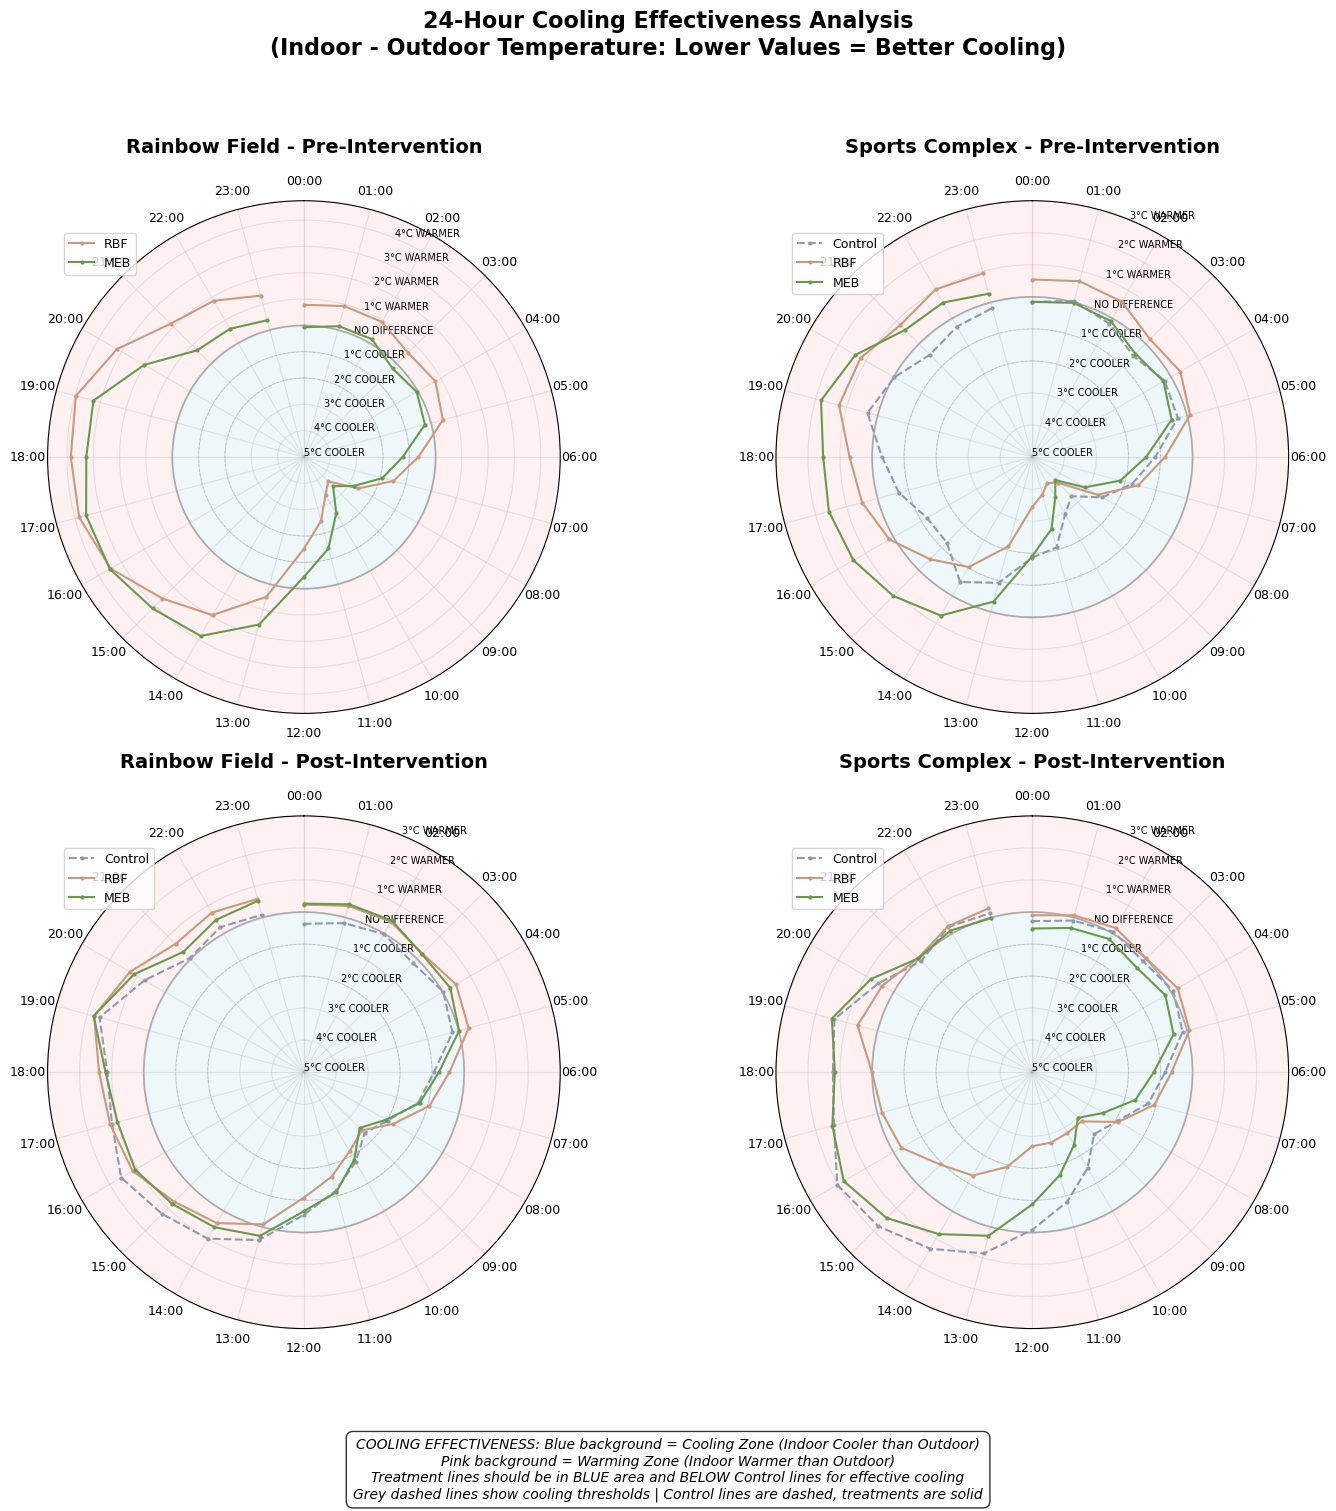


SUMMARY STATISTICS FOR RADAR PLOTS

RAINBOW FIELD:

  Pre-intervention:
    Control: No data available
    RBF: Avg=0.725°C, Min=-3.696°C, Max=3.970°C
    MEB: Avg=0.452°C, Min=-3.433°C, Max=3.564°C

  Post-intervention:
    Control: Avg=-0.070°C, Min=-2.320°C, Max=1.604°C
    RBF: Avg=0.064°C, Min=-2.435°C, Max=1.781°C
    MEB: Avg=0.027°C, Min=-2.539°C, Max=1.792°C

SPORTS COMPLEX:

  Pre-intervention:
    Control: Avg=-0.937°C, Min=-3.270°C, Max=0.324°C
    RBF: Avg=-0.619°C, Min=-4.062°C, Max=1.244°C
    MEB: Avg=-0.401°C, Min=-3.984°C, Max=1.827°C

  Post-intervention:
    Control: Avg=0.069°C, Min=-2.269°C, Max=2.027°C
    RBF: Avg=-0.711°C, Min=-2.826°C, Max=0.645°C
    MEB: Avg=-0.248°C, Min=-2.986°C, Max=1.795°C

DATA COMPLETENESS CHECK

Hours of data available for each condition (should be 24):
        Settlement   Post Treatment_Type  Hours_Available
0    Rainbow Field  False            MEB               24
1    Rainbow Field  False            RBF               24
2    Rain

In [14]:
# Four Radar Plots: Temperature Difference Analysis by Settlement and Period
# Layout: Left column = Rainbow Field, Right column = Sports Complex
#         Top row = Pre-intervention, Bottom row = Post-intervention

fig, axs = plt.subplots(2, 2, figsize=(18, 16), subplot_kw={'projection': 'polar'})

# Calculate hourly effects by settlement, treatment type, and period
# Use Treatment_Type (Control, RBF, MEB) instead of boolean Treatment
hourly_effects = did_df.groupby(['Hour', 'Treatment_Type', 'Settlement', 'Post'])['Temperature_Difference'].mean().reset_index()

# Verify data structure
print("Data structure check:")
print(f"Treatment types available: {hourly_effects['Treatment_Type'].unique()}")
print(f"Settlements available: {hourly_effects['Settlement'].unique()}")
print(f"Post values: {hourly_effects['Post'].unique()}")
print(f"Hour range: {hourly_effects['Hour'].min()} to {hourly_effects['Hour'].max()}")

# Define colors for consistent treatment representation
treatment_colors = {
    'Control': '#8E9AAF',    # Sophisticated blue-gray
    'RBF': '#CB997E',        # Warm terracotta 
    'MEB': '#6A994E'         # Sage green
}

# Function to create radar plot
def create_radar_plot(ax, data, title):
    theta = np.linspace(0, 2*np.pi, 24, endpoint=False)
    
    # Find the data range for this specific plot to set appropriate axis limits
    all_values = []
    for treatment_type in ['Control', 'RBF', 'MEB']:
        treatment_data = data[data['Treatment_Type'] == treatment_type]
        if len(treatment_data) == 24:
            treatment_data = treatment_data.sort_values('Hour')
            all_values.extend(treatment_data['Temperature_Difference'].values)
    
    # Plot each treatment type
    for treatment_type in ['Control', 'RBF', 'MEB']:
        treatment_data = data[data['Treatment_Type'] == treatment_type]
        if len(treatment_data) == 24:  # Ensure we have data for all 24 hours
            # Sort by hour to ensure proper ordering
            treatment_data = treatment_data.sort_values('Hour')
            values = treatment_data['Temperature_Difference'].values
            
            # Set line style - dashed for control, solid for treatments
            line_style = '--' if treatment_type == 'Control' else '-'
            
            ax.plot(theta, values, 
                   color=treatment_colors[treatment_type], 
                   linewidth=1.5, 
                   label=treatment_type,
                   marker='o', 
                   markersize=2,
                   linestyle=line_style)
            # Remove shaded areas as requested
        else:
            print(f"Warning: {treatment_type} has {len(treatment_data)} hours of data (expected 24)")
    
    # Customize the plot
    ax.set_theta_direction(-1)  # Clockwise
    ax.set_theta_offset(np.pi/2.0)  # Start at top (12:00)
    ax.set_xticks(theta)
    ax.set_xticklabels([f'{i:02d}:00' for i in range(24)], fontsize=9)
    ax.set_title(title, pad=35, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.95), fontsize=9)
    
    # Set radial limits based on data range - adjust for out of range values
    if all_values:
        min_val = min(all_values)
        max_val = max(all_values)
        # Add some padding and ensure reasonable range
        range_padding = (max_val - min_val) * 0.1
        y_min = min(-5, min_val - range_padding)  # At least -5 for cooling effectiveness
        y_max = max(3, max_val + range_padding)   # At least 3 for heating
        ax.set_ylim(y_min, y_max)
        
        # Create appropriate tick marks
        tick_range = np.arange(int(y_min), int(y_max) + 1)
        ax.set_yticks(tick_range)
        tick_labels = []
        for val in tick_range:
            if val < 0:
                tick_labels.append(f'{abs(val)}°C COOLER')
            elif val == 0:
                tick_labels.append('NO DIFFERENCE')
            else:
                tick_labels.append(f'{val}°C WARMER')
        ax.set_yticklabels(tick_labels, fontsize=7)
    else:
        # Default range if no data
        ax.set_ylim(-3, 3)
        ax.set_yticks([-3, -2, -1, 0, 1, 2, 3])
        ax.set_yticklabels(['3°C COOLER', '2°C COOLER', '1°C COOLER', 'NO DIFFERENCE', 
                           '1°C WARMER', '2°C WARMER', '3°C WARMER'], fontsize=7)
    
    # Add background shading for cooling/warming zones
    theta_full = np.linspace(0, 2*np.pi, 100)  # More points for smoother circles
    
    # Get current axis limits
    y_min, y_max = ax.get_ylim()
    
    # Blue background for cooling area (negative values)
    if y_min < 0:
        cooling_min = y_min
        cooling_max = min(0, y_max)
        ax.fill_between(theta_full, cooling_min, cooling_max, 
                       color='lightblue', alpha=0.2, zorder=0)
    
    # Pastel pink background for warming area (positive values) 
    if y_max > 0:
        warming_min = max(0, y_min)
        warming_max = y_max
        ax.fill_between(theta_full, warming_min, warming_max, 
                       color='lightpink', alpha=0.2, zorder=0)
    
    # Add reference lines
    ax.axhline(y=0, color='grey', linestyle='-', alpha=0.6, linewidth=1.2, zorder=1)  # No difference line
    if y_min <= -1:
        ax.axhline(y=-1, color='grey', linestyle='--', alpha=0.4, linewidth=0.6, zorder=1)
    if y_min <= -2:
        ax.axhline(y=-2, color='grey', linestyle='--', alpha=0.4, linewidth=0.6, zorder=1)

# TOP LEFT: Rainbow Field - Pre-intervention
rainbow_pre = hourly_effects[
    (hourly_effects['Settlement'] == 'Rainbow Field') & 
    (hourly_effects['Post'] == False)
]
create_radar_plot(axs[0, 0], rainbow_pre, 'Rainbow Field - Pre-Intervention')

# BOTTOM LEFT: Rainbow Field - Post-intervention  
rainbow_post = hourly_effects[
    (hourly_effects['Settlement'] == 'Rainbow Field') & 
    (hourly_effects['Post'] == True)
]
create_radar_plot(axs[1, 0], rainbow_post, 'Rainbow Field - Post-Intervention')

# TOP RIGHT: Sports Complex - Pre-intervention
sports_pre = hourly_effects[
    (hourly_effects['Settlement'] == 'Sports Complex') & 
    (hourly_effects['Post'] == False)
]
create_radar_plot(axs[0, 1], sports_pre, 'Sports Complex - Pre-Intervention')

# BOTTOM RIGHT: Sports Complex - Post-intervention
sports_post = hourly_effects[
    (hourly_effects['Settlement'] == 'Sports Complex') & 
    (hourly_effects['Post'] == True)
]
create_radar_plot(axs[1, 1], sports_post, 'Sports Complex - Post-Intervention')

# Add overall title and layout adjustments
fig.suptitle('24-Hour Cooling Effectiveness Analysis\n(Indoor - Outdoor Temperature: Lower Values = Better Cooling)', 
             fontsize=16, fontweight='bold', y=0.95)

# Add explanatory text emphasizing cooling effectiveness
fig.text(0.5, 0.02, 
         'COOLING EFFECTIVENESS: Blue background = Cooling Zone (Indoor Cooler than Outdoor)\n' +
         'Pink background = Warming Zone (Indoor Warmer than Outdoor)\n' +
         'Treatment lines should be in BLUE area and BELOW Control lines for effective cooling\n' +
         'Grey dashed lines show cooling thresholds | Control lines are dashed, treatments are solid',
         ha='center', fontsize=10, style='italic', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.10, 1, 0.92])
plt.subplots_adjust(wspace=-0.3, hspace=0.2)  # Aggressive spacing reduction
plt.savefig('temperature_difference_radar_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for verification
print("\n" + "="*80)
print("SUMMARY STATISTICS FOR RADAR PLOTS")
print("="*80)

for settlement in ['Rainbow Field', 'Sports Complex']:
    print(f"\n{settlement.upper()}:")
    settlement_data = hourly_effects[hourly_effects['Settlement'] == settlement]
    
    for period in [False, True]:
        period_name = "Pre-intervention" if not period else "Post-intervention"
        period_data = settlement_data[settlement_data['Post'] == period]
        
        print(f"\n  {period_name}:")
        for treatment in ['Control', 'RBF', 'MEB']:
            treatment_data = period_data[period_data['Treatment_Type'] == treatment]
            if len(treatment_data) > 0:
                avg_temp_diff = treatment_data['Temperature_Difference'].mean()
                min_temp_diff = treatment_data['Temperature_Difference'].min()
                max_temp_diff = treatment_data['Temperature_Difference'].max()
                print(f"    {treatment}: Avg={avg_temp_diff:.3f}°C, Min={min_temp_diff:.3f}°C, Max={max_temp_diff:.3f}°C")
            else:
                print(f"    {treatment}: No data available")

# Check data completeness
print("\n" + "="*80)
print("DATA COMPLETENESS CHECK")
print("="*80)

completeness_check = hourly_effects.groupby(['Settlement', 'Post', 'Treatment_Type']).size().reset_index(name='Hours_Available')
print("\nHours of data available for each condition (should be 24):")
print(completeness_check)

missing_hours = completeness_check[completeness_check['Hours_Available'] != 24]
if len(missing_hours) > 0:
    print(f"\nWARNING: {len(missing_hours)} conditions have incomplete hourly data:")
    print(missing_hours)
else:
    print("\n✓ All conditions have complete 24-hour data")

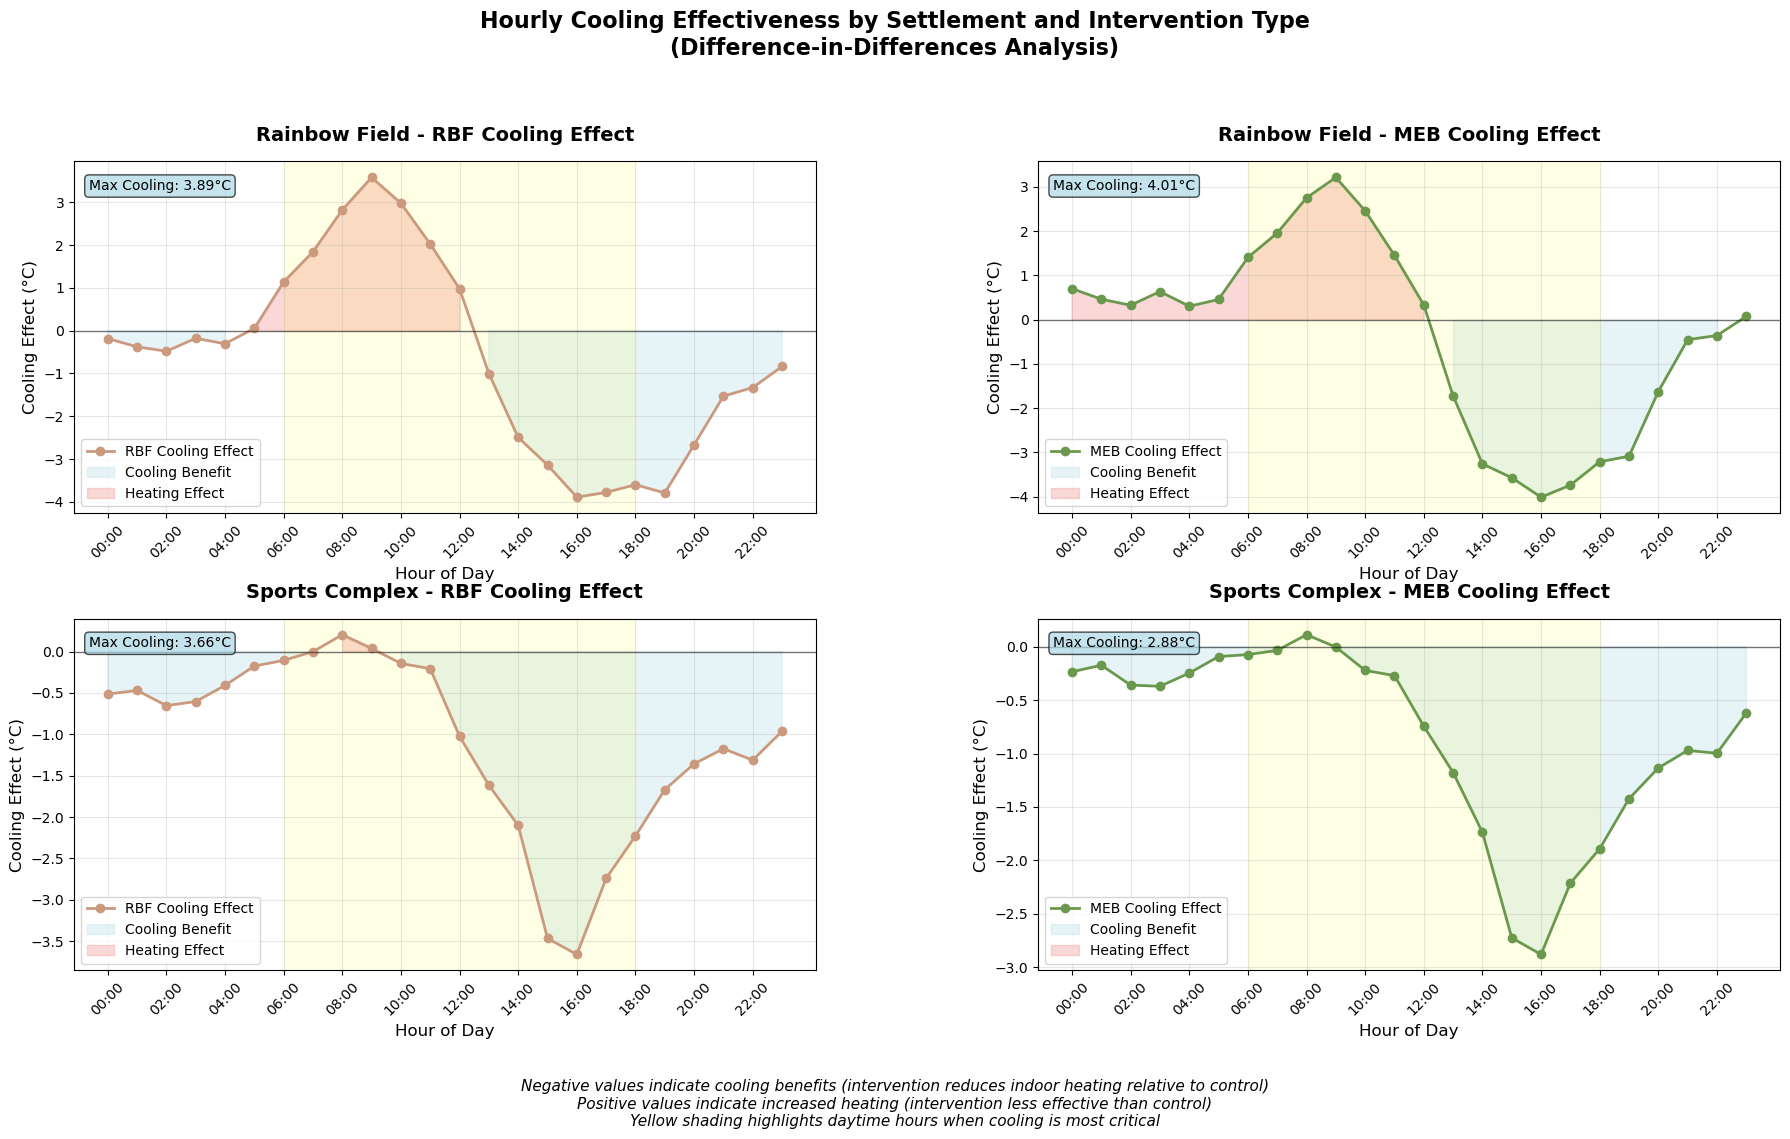

HOURLY COOLING EFFECT SUMMARY

RAINBOW FIELD:
  RBF:
    Average 24h effect: -0.591°C
    Maximum cooling: 3.891°C
    Average daytime effect: -0.195°C
  MEB:
    Average 24h effect: -0.356°C
    Maximum cooling: 4.014°C
    Average daytime effect: -0.458°C

SPORTS COMPLEX:
  RBF:
    Average 24h effect: -1.098°C
    Maximum cooling: 3.659°C
    Average daytime effect: -1.312°C
  MEB:
    Average 24h effect: -0.853°C
    Maximum cooling: 2.880°C
    Average daytime effect: -1.066°C


In [25]:
# Hourly Cooling Effect Analysis by Settlement and Intervention
# Create 4 plots showing cooling effectiveness for each settlement-intervention combination

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Calculate hourly cooling effects (DiD estimator by hour)
def calculate_hourly_cooling_effect(settlement, intervention_type):
    """Calculate hourly cooling effect using difference-in-differences approach"""
    
    # Filter data for specific settlement
    settlement_data = did_df[did_df['Settlement'] == settlement]
    
    # Get treatment and control groups for this settlement
    treatment_data = settlement_data[settlement_data['Treatment_Type'] == intervention_type]
    control_data = settlement_data[settlement_data['Treatment_Type'] == 'Control']
    
    hourly_effects = []
    hours = []
    
    for hour in range(24):
        # Treatment group: Post - Pre
        treatment_hour = treatment_data[treatment_data['Hour'] == hour]
        if len(treatment_hour) > 0:
            treatment_post = treatment_hour[treatment_hour['Post'] == True]['Temperature_Difference'].mean()
            treatment_pre = treatment_hour[treatment_hour['Post'] == False]['Temperature_Difference'].mean()
            treatment_effect = treatment_post - treatment_pre if not np.isnan(treatment_pre) else treatment_post
        else:
            treatment_effect = 0
            
        # Control group: Post - Pre  
        control_hour = control_data[control_data['Hour'] == hour]
        if len(control_hour) > 0:
            control_post = control_hour[control_hour['Post'] == True]['Temperature_Difference'].mean()
            control_pre = control_hour[control_hour['Post'] == False]['Temperature_Difference'].mean()
            control_effect = control_post - control_pre if not np.isnan(control_pre) else control_post
        else:
            control_effect = 0
            
        # DiD Effect: (Treatment_Post - Treatment_Pre) - (Control_Post - Control_Pre)
        cooling_effect = treatment_effect - control_effect
        
        hourly_effects.append(cooling_effect)
        hours.append(hour)
    
    return hours, hourly_effects

# Define colors for consistency
colors = {
    'RBF': '#CB997E',        # Warm terracotta 
    'MEB': '#6A994E'         # Sage green
}

# Plot configurations
plot_configs = [
    (0, 0, 'Rainbow Field', 'RBF', 'Rainbow Field - RBF Cooling Effect'),
    (0, 1, 'Rainbow Field', 'MEB', 'Rainbow Field - MEB Cooling Effect'),
    (1, 0, 'Sports Complex', 'RBF', 'Sports Complex - RBF Cooling Effect'),
    (1, 1, 'Sports Complex', 'MEB', 'Sports Complex - MEB Cooling Effect')
]

for row, col, settlement, intervention, title in plot_configs:
    ax = axes[row, col]
    
    # Calculate cooling effects
    hours, cooling_effects = calculate_hourly_cooling_effect(settlement, intervention)
    
    # Create the plot
    ax.plot(hours, cooling_effects, 
           color=colors[intervention], 
           linewidth=2, 
           marker='o', 
           markersize=6,
           label=f'{intervention} Cooling Effect')
    
    # Fill area to show cooling vs heating
    ax.fill_between(hours, cooling_effects, 0, 
                   where=np.array(cooling_effects) < 0, 
                   color='lightblue', alpha=0.3, label='Cooling Benefit')
    ax.fill_between(hours, cooling_effects, 0, 
                   where=np.array(cooling_effects) > 0, 
                   color='lightcoral', alpha=0.3, label='Heating Effect')
    
    # Add reference line at zero
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    
    # Customize plot
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Hour of Day', fontsize=12)
    ax.set_ylabel('Cooling Effect (°C)', fontsize=12)
    ax.set_xticks(range(0, 24, 2))
    ax.set_xticklabels([f'{i:02d}:00' for i in range(0, 24, 2)], rotation=45)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    # Highlight daytime hours (6 AM - 6 PM)
    ax.axvspan(6, 18, alpha=0.1, color='yellow', label='Daytime Hours')
    
    # Add effect magnitude text
    max_cooling = min(cooling_effects) if min(cooling_effects) < 0 else 0
    if max_cooling < 0:
        ax.text(0.02, 0.95, f'Max Cooling: {abs(max_cooling):.2f}°C', 
               transform=ax.transAxes, fontsize=10, 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
               verticalalignment='top')

# Overall figure formatting
fig.suptitle('Hourly Cooling Effectiveness by Settlement and Intervention Type\n(Difference-in-Differences Analysis)', 
             fontsize=16, fontweight='bold', y=0.95)

# Add explanatory text
fig.text(0.5, 0.02, 
         'Negative values indicate cooling benefits (intervention reduces indoor heating relative to control)\n' +
         'Positive values indicate increased heating (intervention less effective than control)\n' +
         'Yellow shading highlights daytime hours when cooling is most critical',
         ha='center', fontsize=11, style='italic')

plt.tight_layout(rect=[0, 0.08, 1, 0.92])
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.savefig('hourly_cooling_effects_by_intervention.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("="*80)
print("HOURLY COOLING EFFECT SUMMARY")
print("="*80)

for settlement in ['Rainbow Field', 'Sports Complex']:
    print(f"\n{settlement.upper()}:")
    for intervention in ['RBF', 'MEB']:
        hours, effects = calculate_hourly_cooling_effect(settlement, intervention)
        avg_effect = np.mean(effects)
        max_cooling = min(effects)
        daytime_effects = [effects[i] for i in range(6, 19)]  # 6 AM to 6 PM
        avg_daytime = np.mean(daytime_effects)
        
        print(f"  {intervention}:")
        print(f"    Average 24h effect: {avg_effect:.3f}°C")
        print(f"    Maximum cooling: {abs(max_cooling):.3f}°C")
        print(f"    Average daytime effect: {avg_daytime:.3f}°C")


C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_13052\1278373374.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 0.90, 0.92])


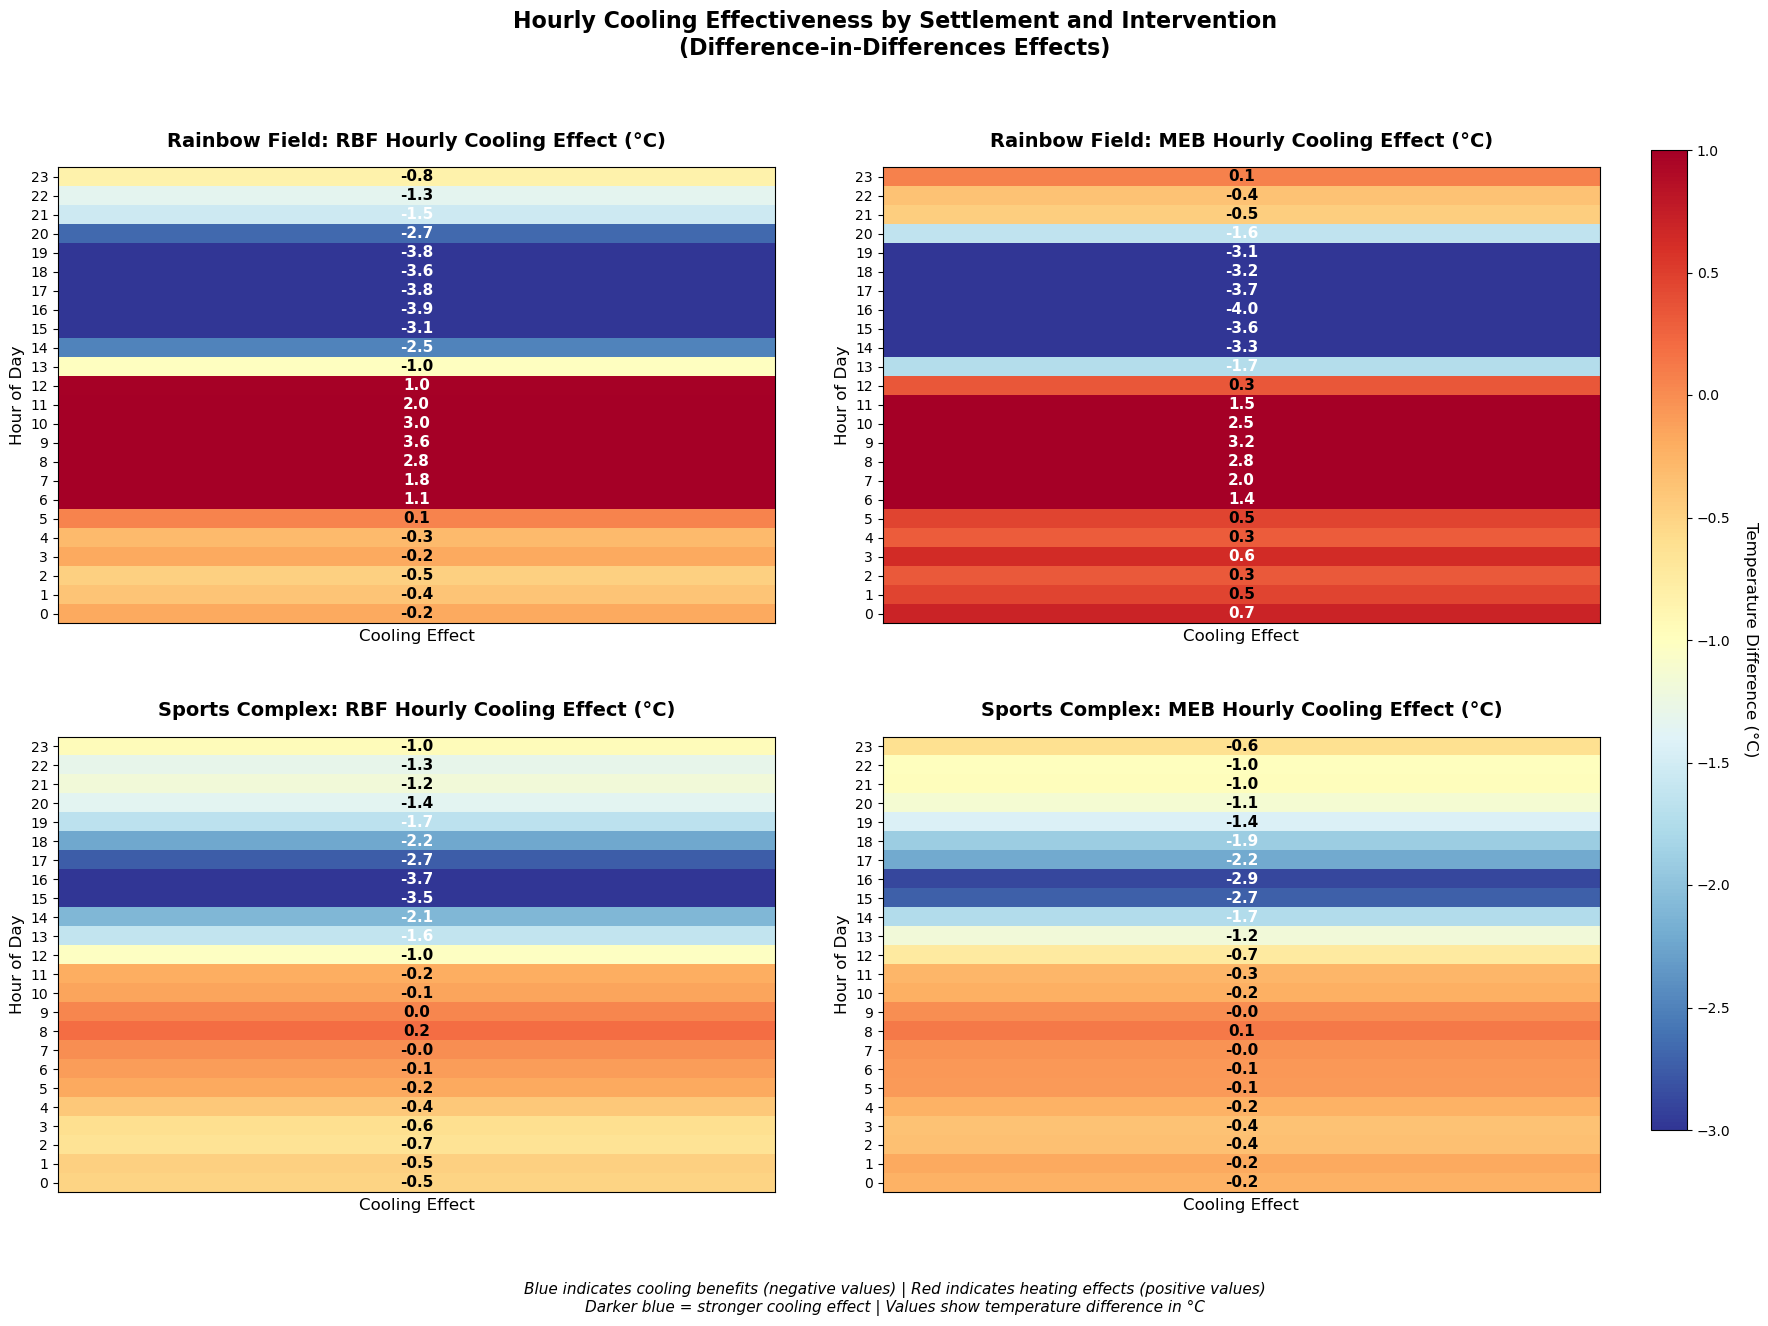

PEAK COOLING HOURS ANALYSIS

Top 3 Cooling Hours and Day/Night Averages:
    Settlement Intervention     Peak_Hour_1     Peak_Hour_2     Peak_Hour_3 Avg_Daytime Avg_Nighttime
 Rainbow Field          RBF 16:00 (-3.89°C) 19:00 (-3.79°C) 17:00 (-3.78°C)     -0.20°C       -1.06°C
 Rainbow Field          MEB 16:00 (-4.01°C) 17:00 (-3.74°C) 15:00 (-3.57°C)     -0.46°C       -0.23°C
Sports Complex          RBF 16:00 (-3.66°C) 15:00 (-3.47°C) 17:00 (-2.74°C)     -1.31°C       -0.85°C
Sports Complex          MEB 16:00 (-2.88°C) 15:00 (-2.72°C) 17:00 (-2.21°C)     -1.07°C       -0.60°C

INTERVENTION EFFECTIVENESS RANKING

Ranked by Average 24-Hour Cooling Performance:
Sports Complex - RBF: -1.098°C avg, 3.66°C max cooling
Sports Complex - MEB: -0.853°C avg, 2.88°C max cooling
Rainbow Field - RBF: -0.591°C avg, 3.89°C max cooling
Rainbow Field - MEB: -0.356°C avg, 4.01°C max cooling


In [26]:
# Hour-by-Hour Cooling Effect Heatmaps by Settlement and Intervention
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Define the cooling effect calculation function (in case it's not available from previous cell)
def calculate_hourly_cooling_effect_safe(settlement, intervention_type):
    """Calculate hourly cooling effect using difference-in-differences approach with error handling"""
    
    try:
        # Filter data for specific settlement
        settlement_data = did_df[did_df['Settlement'] == settlement]
        
        # Get treatment and control groups for this settlement
        treatment_data = settlement_data[settlement_data['Treatment_Type'] == intervention_type]
        control_data = settlement_data[settlement_data['Treatment_Type'] == 'Control']
        
        hourly_effects = []
        hours = []
        
        for hour in range(24):
            # Treatment group: Post - Pre
            treatment_hour = treatment_data[treatment_data['Hour'] == hour]
            if len(treatment_hour) > 0:
                treatment_post_data = treatment_hour[treatment_hour['Post'] == True]['Temperature_Difference']
                treatment_pre_data = treatment_hour[treatment_hour['Post'] == False]['Temperature_Difference']
                
                treatment_post = treatment_post_data.mean() if len(treatment_post_data) > 0 else 0
                treatment_pre = treatment_pre_data.mean() if len(treatment_pre_data) > 0 else 0
                treatment_effect = treatment_post - treatment_pre
            else:
                treatment_effect = 0
                
            # Control group: Post - Pre  
            control_hour = control_data[control_data['Hour'] == hour]
            if len(control_hour) > 0:
                control_post_data = control_hour[control_hour['Post'] == True]['Temperature_Difference']
                control_pre_data = control_hour[control_hour['Post'] == False]['Temperature_Difference']
                
                control_post = control_post_data.mean() if len(control_post_data) > 0 else 0
                control_pre = control_pre_data.mean() if len(control_pre_data) > 0 else 0
                control_effect = control_post - control_pre
            else:
                control_effect = 0
                
            # DiD Effect: (Treatment_Post - Treatment_Pre) - (Control_Post - Control_Pre)
            cooling_effect = treatment_effect - control_effect
            
            # Handle NaN values
            if np.isnan(cooling_effect):
                cooling_effect = 0
                
            hourly_effects.append(cooling_effect)
            hours.append(hour)
        
        return hours, hourly_effects
    
    except Exception as e:
        print(f"Error calculating effects for {settlement} - {intervention_type}: {e}")
        # Return default values
        return list(range(24)), [0] * 24

# Calculate hourly cooling effects for each settlement-intervention combination
def get_hourly_effects_matrix(settlement, intervention):
    """Get hourly cooling effects as a matrix for heatmap"""
    hours, effects = calculate_hourly_cooling_effect_safe(settlement, intervention)
    # Convert to matrix format (24 rows x 1 column)
    effects_matrix = np.array(effects).reshape(24, 1)
    return effects_matrix, effects

# Plot configurations
plot_configs = [
    (0, 0, 'Rainbow Field', 'RBF', 'Rainbow Field: RBF Hourly Cooling Effect (°C)'),
    (0, 1, 'Rainbow Field', 'MEB', 'Rainbow Field: MEB Hourly Cooling Effect (°C)'),
    (1, 0, 'Sports Complex', 'RBF', 'Sports Complex: RBF Hourly Cooling Effect (°C)'),
    (1, 1, 'Sports Complex', 'MEB', 'Sports Complex: MEB Hourly Cooling Effect (°C)')
]

# Define common color scale limits for comparison
vmin = -3.0
vmax = 1.0

for row, col, settlement, intervention, title in plot_configs:
    ax = axes[row, col]
    
    # Get cooling effects matrix
    effects_matrix, effects_list = get_hourly_effects_matrix(settlement, intervention)
    
    # Create heatmap
    im = ax.imshow(effects_matrix, 
                   cmap='RdYlBu_r',  # Red-Yellow-Blue reversed (blue for cooling)
                   aspect='auto',
                   vmin=vmin, vmax=vmax,
                   interpolation='nearest')
    
    # Add text annotations
    for i in range(24):
        text_color = 'white' if effects_list[i] < -1.5 or effects_list[i] > 0.5 else 'black'
        ax.text(0, i, f'{effects_list[i]:.1f}', 
               ha='center', va='center', 
               fontsize=11, fontweight='bold',
               color=text_color)
    
    # Customize axes
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('Hour of Day', fontsize=12)
    ax.set_xlabel('Cooling Effect', fontsize=12)
    
    # Set y-axis ticks and labels
    ax.set_yticks(range(24))
    ax.set_yticklabels([f'{i}' for i in range(24)])
    
    # Remove x-axis ticks (single column)
    ax.set_xticks([])
    
    # Add grid
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 23.5)

# Add a single colorbar for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Temperature Difference (°C)', fontsize=12, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=10)

# Add overall title
fig.suptitle('Hourly Cooling Effectiveness by Settlement and Intervention\n(Difference-in-Differences Effects)', 
             fontsize=16, fontweight='bold', y=0.95)

# Add explanatory text
fig.text(0.5, 0.02, 
         'Blue indicates cooling benefits (negative values) | Red indicates heating effects (positive values)\n' +
         'Darker blue = stronger cooling effect | Values show temperature difference in °C',
         ha='center', fontsize=11, style='italic')

plt.tight_layout(rect=[0, 0.08, 0.90, 0.92])
plt.subplots_adjust(hspace=0.25, wspace=0.15)
plt.savefig('hourly_cooling_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# Create summary table showing peak cooling hours
print("="*80)
print("PEAK COOLING HOURS ANALYSIS")
print("="*80)

summary_data = []
for settlement in ['Rainbow Field', 'Sports Complex']:
    for intervention in ['RBF', 'MEB']:
        hours, effects = calculate_hourly_cooling_effect_safe(settlement, intervention)
        
        # Find hours with strongest cooling (most negative values)
        effects_with_hours = list(zip(hours, effects))
        sorted_effects = sorted(effects_with_hours, key=lambda x: x[1])
        
        # Get top 3 cooling hours
        top_cooling = sorted_effects[:3]
        
        # Calculate daytime vs nighttime averages
        daytime_effects = [effects[i] for i in range(6, 19)]  # 6 AM to 6 PM
        nighttime_effects = [effects[i] for i in list(range(0, 6)) + list(range(19, 24))]
        
        summary_data.append({
            'Settlement': settlement,
            'Intervention': intervention,
            'Peak_Hour_1': f"{top_cooling[0][0]:02d}:00 ({top_cooling[0][1]:.2f}°C)",
            'Peak_Hour_2': f"{top_cooling[1][0]:02d}:00 ({top_cooling[1][1]:.2f}°C)", 
            'Peak_Hour_3': f"{top_cooling[2][0]:02d}:00 ({top_cooling[2][1]:.2f}°C)",
            'Avg_Daytime': f"{np.mean(daytime_effects):.2f}°C",
            'Avg_Nighttime': f"{np.mean(nighttime_effects):.2f}°C"
        })

# Display summary table
summary_df = pd.DataFrame(summary_data)
print("\nTop 3 Cooling Hours and Day/Night Averages:")
print(summary_df.to_string(index=False))

# Calculate overall effectiveness ranking
print("\n" + "="*80)
print("INTERVENTION EFFECTIVENESS RANKING")
print("="*80)

rankings = []
for settlement in ['Rainbow Field', 'Sports Complex']:
    for intervention in ['RBF', 'MEB']:
        hours, effects = calculate_hourly_cooling_effect_safe(settlement, intervention)
        avg_24h = np.mean(effects)
        max_cooling = min(effects)
        
        rankings.append({
            'Settlement_Intervention': f"{settlement} - {intervention}",
            'Average_24h_Effect': avg_24h,
            'Maximum_Cooling': max_cooling
        })

rankings_df = pd.DataFrame(rankings)
rankings_df = rankings_df.sort_values('Average_24h_Effect')  # Sort by best average (most negative)

print("\nRanked by Average 24-Hour Cooling Performance:")
for idx, row in rankings_df.iterrows():
    print(f"{row['Settlement_Intervention']}: {row['Average_24h_Effect']:.3f}°C avg, {abs(row['Maximum_Cooling']):.2f}°C max cooling")


In [ ]:
# WORKING VERSION: Hour-by-Hour Cooling Effect Heatmaps
print("Creating hourly cooling effect heatmaps...")

# Check data availability first
print(f"Data shape: {did_df.shape}")
print(f"Available settlements: {did_df['Settlement'].unique()}")
print(f"Available treatment types: {did_df['Treatment_Type'].unique()}")

# Define simplified function for cooling effects
def get_cooling_effects(settlement, intervention):
    """Calculate hourly cooling effects with robust error handling"""
    effects = []
    
    try:
        settlement_data = did_df[did_df['Settlement'] == settlement]
        treatment_data = settlement_data[settlement_data['Treatment_Type'] == intervention]
        control_data = settlement_data[settlement_data['Treatment_Type'] == 'Control']
        
        for hour in range(24):
            # Get hourly data
            treat_hour = treatment_data[treatment_data['Hour'] == hour]
            control_hour = control_data[control_data['Hour'] == hour]
            
            # Calculate treatment effect (post - pre)
            if len(treat_hour) > 0:
                treat_post = treat_hour[treat_hour['Post'] == True]['Temperature_Difference'].mean()
                treat_pre = treat_hour[treat_hour['Post'] == False]['Temperature_Difference'].mean()
                treat_effect = (treat_post - treat_pre) if not pd.isna(treat_pre) else treat_post
            else:
                treat_effect = 0
            
            # Calculate control effect (post - pre)
            if len(control_hour) > 0:
                control_post = control_hour[control_hour['Post'] == True]['Temperature_Difference'].mean()
                control_pre = control_hour[control_hour['Post'] == False]['Temperature_Difference'].mean()
                control_effect = (control_post - control_pre) if not pd.isna(control_pre) else control_post
            else:
                control_effect = 0
            
            # DiD effect
            did_effect = treat_effect - control_effect
            effects.append(did_effect if not pd.isna(did_effect) else 0)
            
    except Exception as e:
        print(f"Error for {settlement}-{intervention}: {e}")
        effects = [0] * 24
    
    return effects

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot data
interventions = [
    ('Rainbow Field', 'RBF', 0, 0),
    ('Rainbow Field', 'MEB', 0, 1), 
    ('Sports Complex', 'RBF', 1, 0),
    ('Sports Complex', 'MEB', 1, 1)
]

vmin, vmax = -3.0, 1.0

for settlement, intervention, row, col in interventions:
    ax = axes[row, col]
    effects = get_cooling_effects(settlement, intervention)
    
    # Create heatmap with proper cooling colors
    effects_matrix = np.array(effects).reshape(24, 1)
    im = ax.imshow(effects_matrix, cmap='RdBu_r', vmin=vmin, vmax=vmax, aspect='auto')
    
    # Add text labels with better contrast for blue cooling colors
    for i, effect in enumerate(effects):
        # White text for strong cooling (dark blue) and strong heating (dark red)
        color = 'white' if effect < -1.0 or effect > 0.8 else 'black'
        ax.text(0, i, f'{effect:.1f}', ha='center', va='center', 
                fontsize=11, fontweight='bold', color=color)
    
    # Format axes
    ax.set_title(f'{settlement}: {intervention} Hourly Cooling Effect (°C)', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('Hour of Day', fontsize=12)
    ax.set_yticks(range(24))
    ax.set_yticklabels([f'{i}' for i in range(24)])
    ax.set_xticks([])

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Temperature Difference (°C)', fontsize=12, rotation=270, labelpad=20)

# Format figure
fig.suptitle('Hourly Cooling Effectiveness by Settlement and Intervention\n(Difference-in-Differences Effects)', 
             fontsize=16, fontweight='bold', y=0.95)

fig.text(0.5, 0.02, 
         'Blue colors = Cooling benefits (indoor cooler than environment) | Red colors = Heating effects | Values in °C',
         ha='center', fontsize=11, style='italic')

plt.tight_layout(rect=[0, 0.08, 0.90, 0.92])
plt.subplots_adjust(hspace=0.25, wspace=0.15)
plt.savefig('hourly_cooling_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("HOURLY COOLING EFFECT SUMMARY")
print("="*60)

for settlement in ['Rainbow Field', 'Sports Complex']:
    print(f"\n{settlement.upper()}:")
    for intervention in ['RBF', 'MEB']:
        effects = get_cooling_effects(settlement, intervention)
        avg_effect = np.mean(effects)
        max_cooling = min(effects)
        
        print(f"  {intervention}: Avg {avg_effect:.3f}°C, Max cooling {abs(max_cooling):.2f}°C")

print("\nHeatmaps created successfully!")
